<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew #for some statistics


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./datasets/housing.csv')
house.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
house.head() #check first 5 rows 

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
house.sample(10) #randomly sample 10 rows
# can observe there is a lot of NaN values

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1086,1087,160,RM,NaN,1974,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,83500
115,116,160,FV,34.0,3230,Pave,Pave,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2007,WD,Normal,176000
761,762,30,RM,60.0,6911,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2009,WD,Normal,100000
620,621,30,RL,45.0,8248,Pave,Grvl,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,67000
462,463,20,RL,60.0,8281,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,GdWo,NaN,0,12,2009,WD,Normal,62383
18,19,20,RL,66.0,13695,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,159000
1382,1383,70,RM,60.0,7200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,10,2006,WD,Normal,157000
1451,1452,20,RL,78.0,9262,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2009,New,Partial,287090
1040,1041,20,RL,88.0,13125,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,1,2006,WD,Normal,155000
17,18,90,RL,72.0,10791,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,Shed,500,10,2006,WD,Normal,90000


In [5]:
#remove any houses that are not residential from the dataset.
house=house[house.MSZoning!='C (all)']
house.MSZoning.unique()

array(['RL', 'RM', 'FV', 'RH'], dtype=object)

In [6]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1450 entries, 0 to 1459
Data columns (total 81 columns):
Id               1450 non-null int64
MSSubClass       1450 non-null int64
MSZoning         1450 non-null object
LotFrontage      1191 non-null float64
LotArea          1450 non-null int64
Street           1450 non-null object
Alley            89 non-null object
LotShape         1450 non-null object
LandContour      1450 non-null object
Utilities        1450 non-null object
LotConfig        1450 non-null object
LandSlope        1450 non-null object
Neighborhood     1450 non-null object
Condition1       1450 non-null object
Condition2       1450 non-null object
BldgType         1450 non-null object
HouseStyle       1450 non-null object
OverallQual      1450 non-null int64
OverallCond      1450 non-null int64
YearBuilt        1450 non-null int64
YearRemodAdd     1450 non-null int64
RoofStyle        1450 non-null object
RoofMatl         1450 non-null object
Exterior1st      1450 non-n

In [7]:
#check number of observations and columns
house.shape

(1450, 81)

In [8]:
house.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1450.000000,1450.000000,1191.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1442.000000,1450.000000,...,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000,1450.000000
mean,731.364138,56.903448,70.052897,10523.831724,6.114483,5.582069,1971.593103,1985.049655,104.404300,445.162759,...,94.826897,46.537931,21.536552,3.433103,15.096552,2.777931,43.365517,6.312414,2007.812414,181654.942069
std,421.554345,42.265033,24.301013,10012.185355,1.372860,1.107330,30.022696,20.552319,181.486539,456.353871,...,125.560863,65.222761,60.838826,29.416948,55.893399,40.315051,497.636495,2.698244,1.326321,79176.485241
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,37900.000000
25%,366.250000,20.000000,59.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,130000.000000
50%,731.500000,50.000000,70.000000,9496.000000,6.000000,5.000000,1973.000000,1994.000000,0.000000,384.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163945.000000
75%,1096.750000,70.000000,80.000000,11613.500000,7.000000,6.000000,2001.000000,2004.000000,166.750000,713.750000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## EDA

### Target variable

Before removing outliers: (1450, 81)
After removing outliers: (1438, 81)


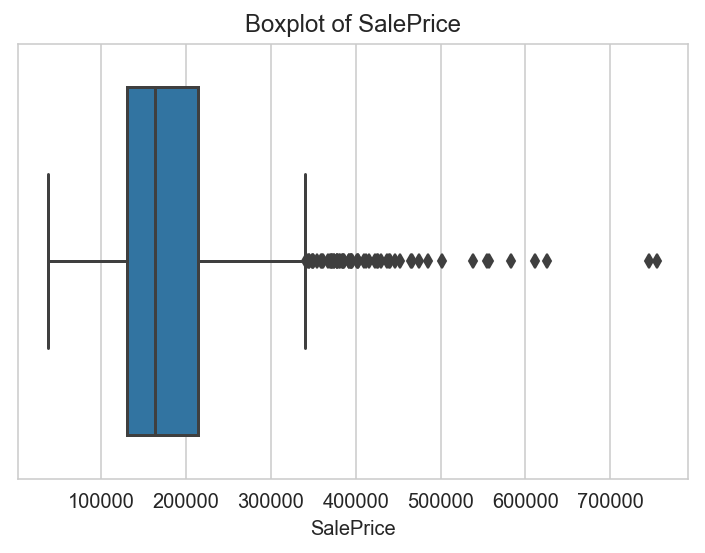

In [9]:
#check outliers of target variable
sns.boxplot('SalePrice',data=house)
plt.title('Boxplot of SalePrice');

# Computing IQR
print(f'Before removing outliers: {house.shape}')
Q1 = house.SalePrice.quantile(0.25)
Q3 = house.SalePrice.quantile(0.75)
IQR = Q3 - Q1

# Filtering Values between Q1-3.0 IQR and Q3+3.0 IQR ( More conservative setting )
house = house.query('(@Q1 - 3.0 * @IQR) <= SalePrice <= (@Q3 + 3.0 * @IQR)')
print(f'After removing outliers: {house.shape}')

C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


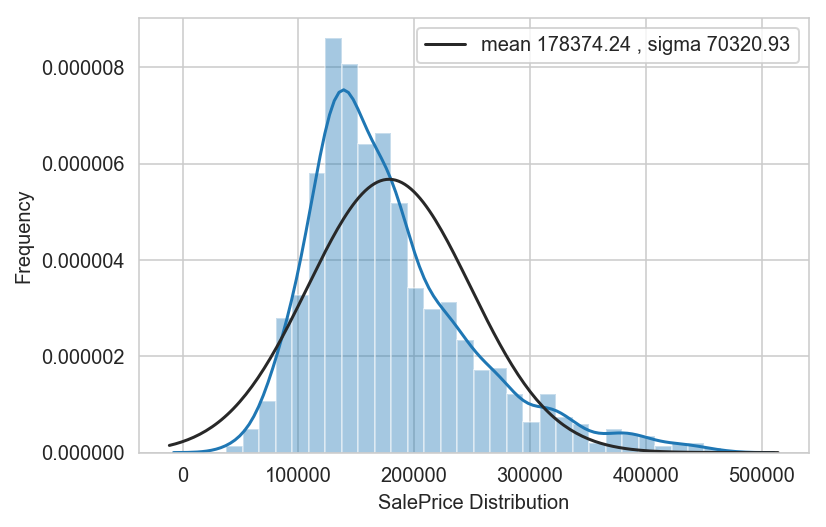

In [10]:
#Histogram shows the SalePrice is skewed to the right
#Mean price is around $181,654
sns.distplot(house.SalePrice,fit=norm) 
plt.xlabel('SalePrice Distribution')
plt.ylabel('Frequency')
(mu,sigma) = norm.fit(house.SalePrice)
plt.legend(['mean {:.2f} , sigma {:.2f}'.format(mu,sigma)],loc='best');

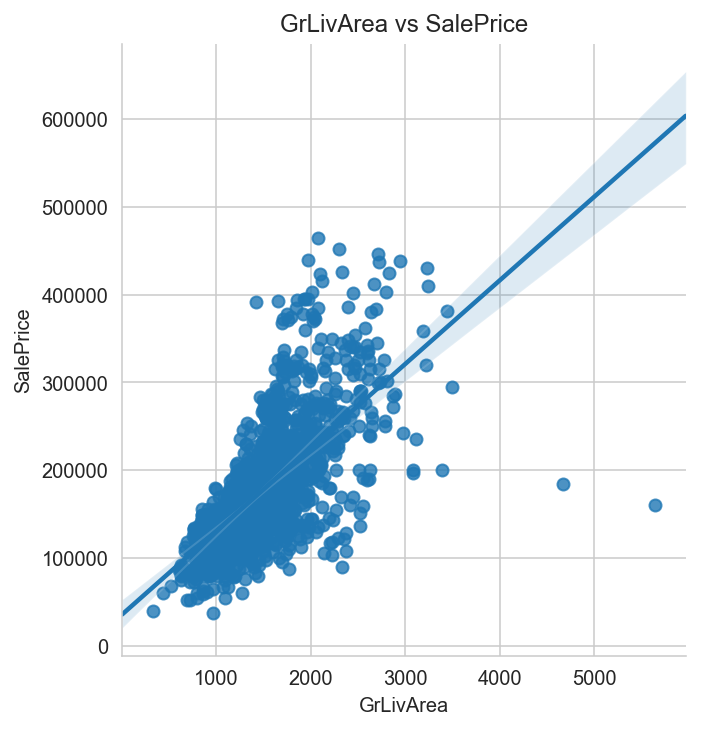

In [11]:
sns.lmplot(x='GrLivArea',y='SalePrice',data=house)
plt.title('GrLivArea vs SalePrice');

#determine the index of the 2 outliers and drop it
outlier=house[(house.GrLivArea>4500) & (house.SalePrice<200000)].index
house.drop(outlier,inplace=True)

### Missing Data

In [12]:
#check % data that is null
total=pd.DataFrame({'is_null':house.isnull().sum().sort_values(ascending=False)}) #determine columns with missing values
total['Percentage']= total.is_null/len(house)
total=total[total.is_null!=0]
total

,is_null,Percentage
PoolQC,1431,0.996518
MiscFeature,1384,0.963788
Alley,1347,0.938022
Fence,1160,0.807799
FireplaceQu,681,0.474234
LotFrontage,258,0.179666
GarageCond,79,0.055014
GarageType,79,0.055014
GarageYrBlt,79,0.055014
GarageFinish,79,0.055014


In [13]:
house.Electrical.unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [14]:
#drop Id  
#drop Electrical as it's a very basic requirement/necessity and it should be removed
#drop PoolQC as most of the values are unavailable
#both Electrical and PooQC does not provide enough variant to have an impact to the target variable
house.drop(columns=['Electrical','Id','PoolQC'],axis=1,inplace=True)

In [15]:
cat=house.dtypes[house.dtypes=='object'].index #columns that are categorical
cat

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

In [16]:
cont=house.dtypes[house.dtypes!='object'].index #columns that is continuous
cont

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [17]:
# Change the following to categorical variable 'MSSubClass','MoSold' because eventhough they are continuous 
# they behave more like categorical. Also, a higher numerical value of 
# 'MSSubClass'/'MoSold' number doesn't translate to a bigger/better value.

for column in ['MSSubClass','MoSold']:
    house[column]=house[column].astype(str)

#re-run
cat=house.dtypes[house.dtypes=='object'].index #columns that are categorical

### Data Corelation

In [18]:
# assign predictor variable to fixed and renovatable

fixed = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour','LotConfig', 'LandSlope','TotalBsmtSF', 
        'Neighborhood', 'Condition1', 'Condition2','BldgType', 'HouseStyle','Foundation','HalfBath',
        'Functional', 'KitchenAbvGr','EnclosedPorch','PoolArea','GarageType','ScreenPorch','MiscFeature',
        'MSSubClass','GrLivArea','GarageCars','OpenPorchSF','WoodDeckSF','2ndFlrSF','BsmtFullBath','BsmtUnfSF','BedroomAbvGr',
         '3SsnPorch','BsmtFinSF2','MiscVal','BsmtHalfBath','YearBuilt','GarageArea','FullBath','SalePrice',
         'YrSold','1stFlrSF','GarageYrBlt','TotRmsAbvGrd','BsmtFinSF1','LotFrontage']

reno_all= ['OverallQual','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
           'ExterCond','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','BsmtQual',
           'KitchenQual','FireplaceQu','GarageFinish','GarageQual','GarageCond','PavedDrive','Fence','OverallCond',
           'YrSold','SalePrice','Fireplaces','MasVnrArea','LowQualFinSF']

sales = ['SaleType','SaleCondition'] 


In [19]:
#to check co-relation for fixed features
house_corr=house[fixed]

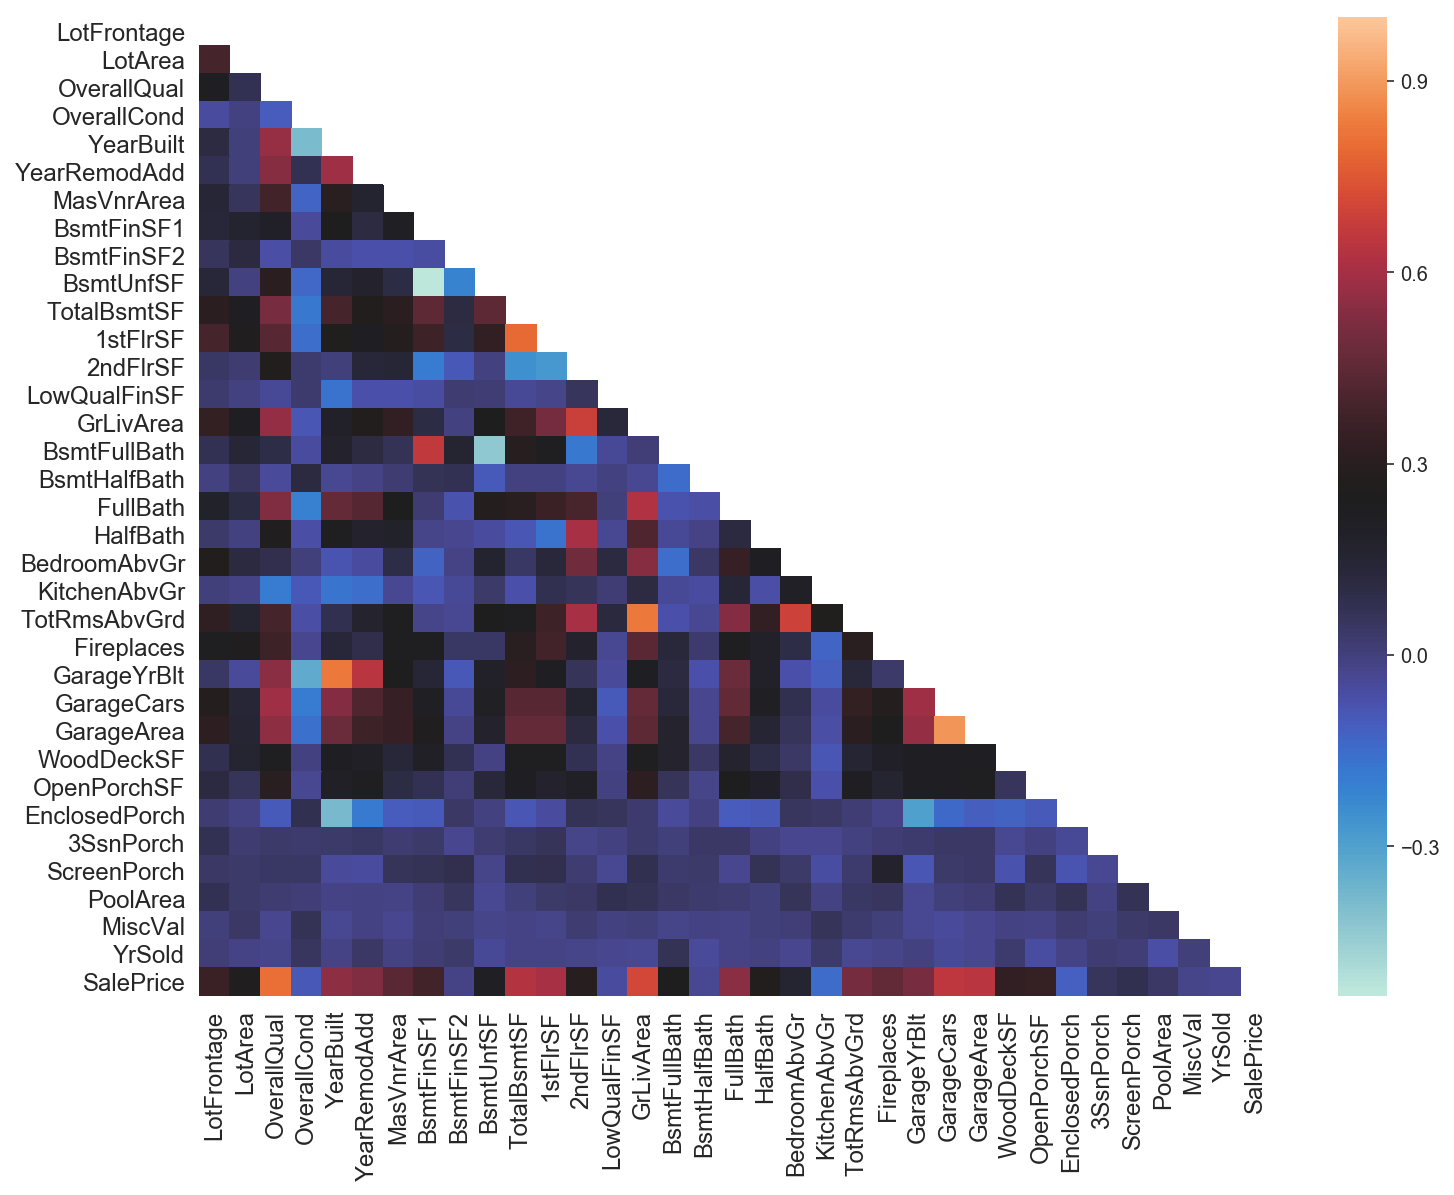

In [20]:
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,9))


    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True


    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, center=0.25,mask=mask, annot=False)


    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12, rotation=0)


    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()
    
correlation_heat_map(house)

Looking at the SalePrice row , co-relation values that are > 0.6 ( red and yellow ) will be considered significant and included in modelling.

In [21]:
#Pearson co-relation with SalePrice
house_corr.corr()['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.707257
GarageCars       0.656562
GarageArea       0.645990
TotalBsmtSF      0.631834
1stFlrSF         0.607940
YearBuilt        0.552208
FullBath         0.549108
GarageYrBlt      0.508885
TotRmsAbvGrd     0.506247
BsmtFinSF1       0.385321
LotFrontage      0.358893
OpenPorchSF      0.346363
WoodDeckSF       0.331092
2ndFlrSF         0.288909
HalfBath         0.275884
BsmtFullBath     0.241160
BsmtUnfSF        0.213223
BedroomAbvGr     0.157757
ScreenPorch      0.080103
3SsnPorch        0.054973
PoolArea         0.037478
BsmtFinSF2      -0.014860
MiscVal         -0.019722
YrSold          -0.030398
BsmtHalfBath    -0.032646
EnclosedPorch   -0.120021
KitchenAbvGr    -0.145975
Name: SalePrice, dtype: float64

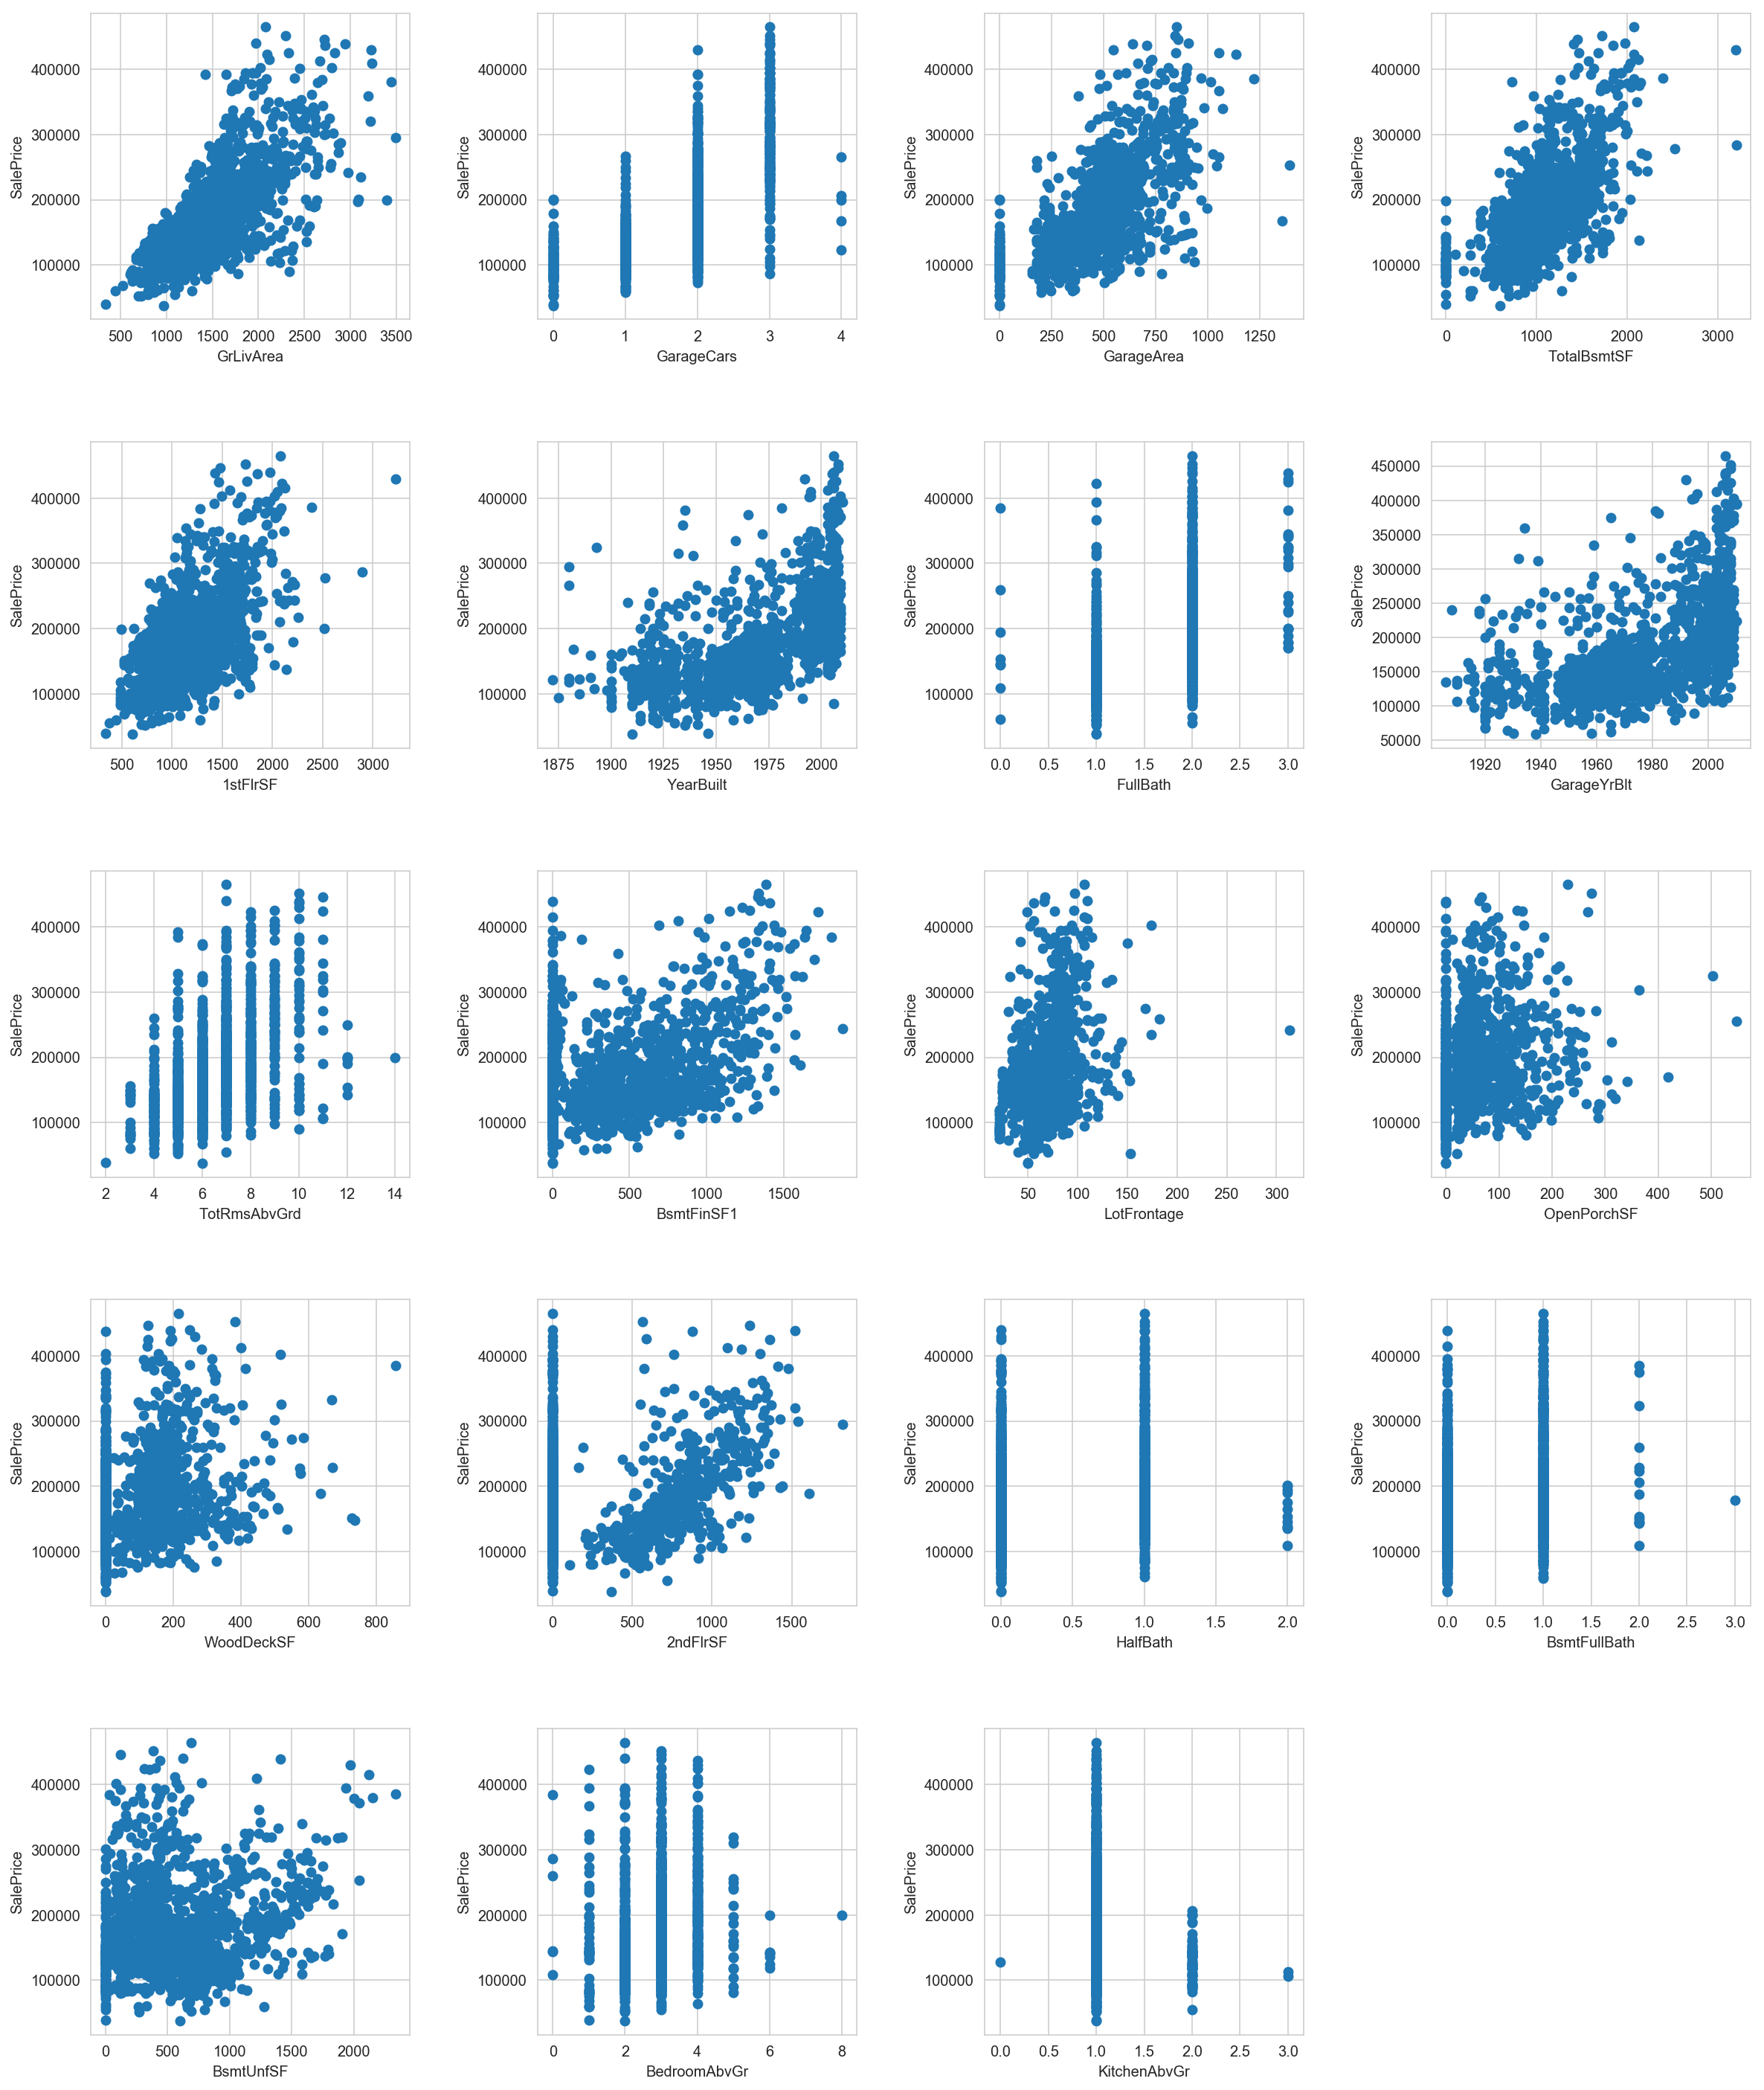

In [22]:
# Plot the first 19 parameters based on Pearson
columns = abs(house_corr.corr(method='pearson')['SalePrice']).sort_values(ascending=False)[1:20].index.values
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 4, i)
    ax.scatter(x=columns[i-1], y='SalePrice', data=house)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('SalePrice')

Based on the charts, we can see that there's linearity observed hence linear regression can be used for modelling.

In [23]:
#Rank Spearman corelation with SalePrice
house_corr.corr(method='spearman')['SalePrice'].sort_values(ascending=False)

SalePrice        1.000000
GrLivArea        0.726735
GarageCars       0.686424
YearBuilt        0.648033
GarageArea       0.647631
FullBath         0.626295
TotalBsmtSF      0.592396
GarageYrBlt      0.589721
1stFlrSF         0.563302
TotRmsAbvGrd     0.523295
OpenPorchSF      0.474796
LotFrontage      0.405481
WoodDeckSF       0.349267
HalfBath         0.333265
BsmtFinSF1       0.293823
2ndFlrSF         0.288289
BedroomAbvGr     0.225320
BsmtFullBath     0.220269
BsmtUnfSF        0.183599
ScreenPorch      0.088614
3SsnPorch        0.067348
PoolArea         0.050703
BsmtHalfBath    -0.014723
YrSold          -0.027117
BsmtFinSF2      -0.042421
MiscVal         -0.051845
KitchenAbvGr    -0.166224
EnclosedPorch   -0.205556
Name: SalePrice, dtype: float64

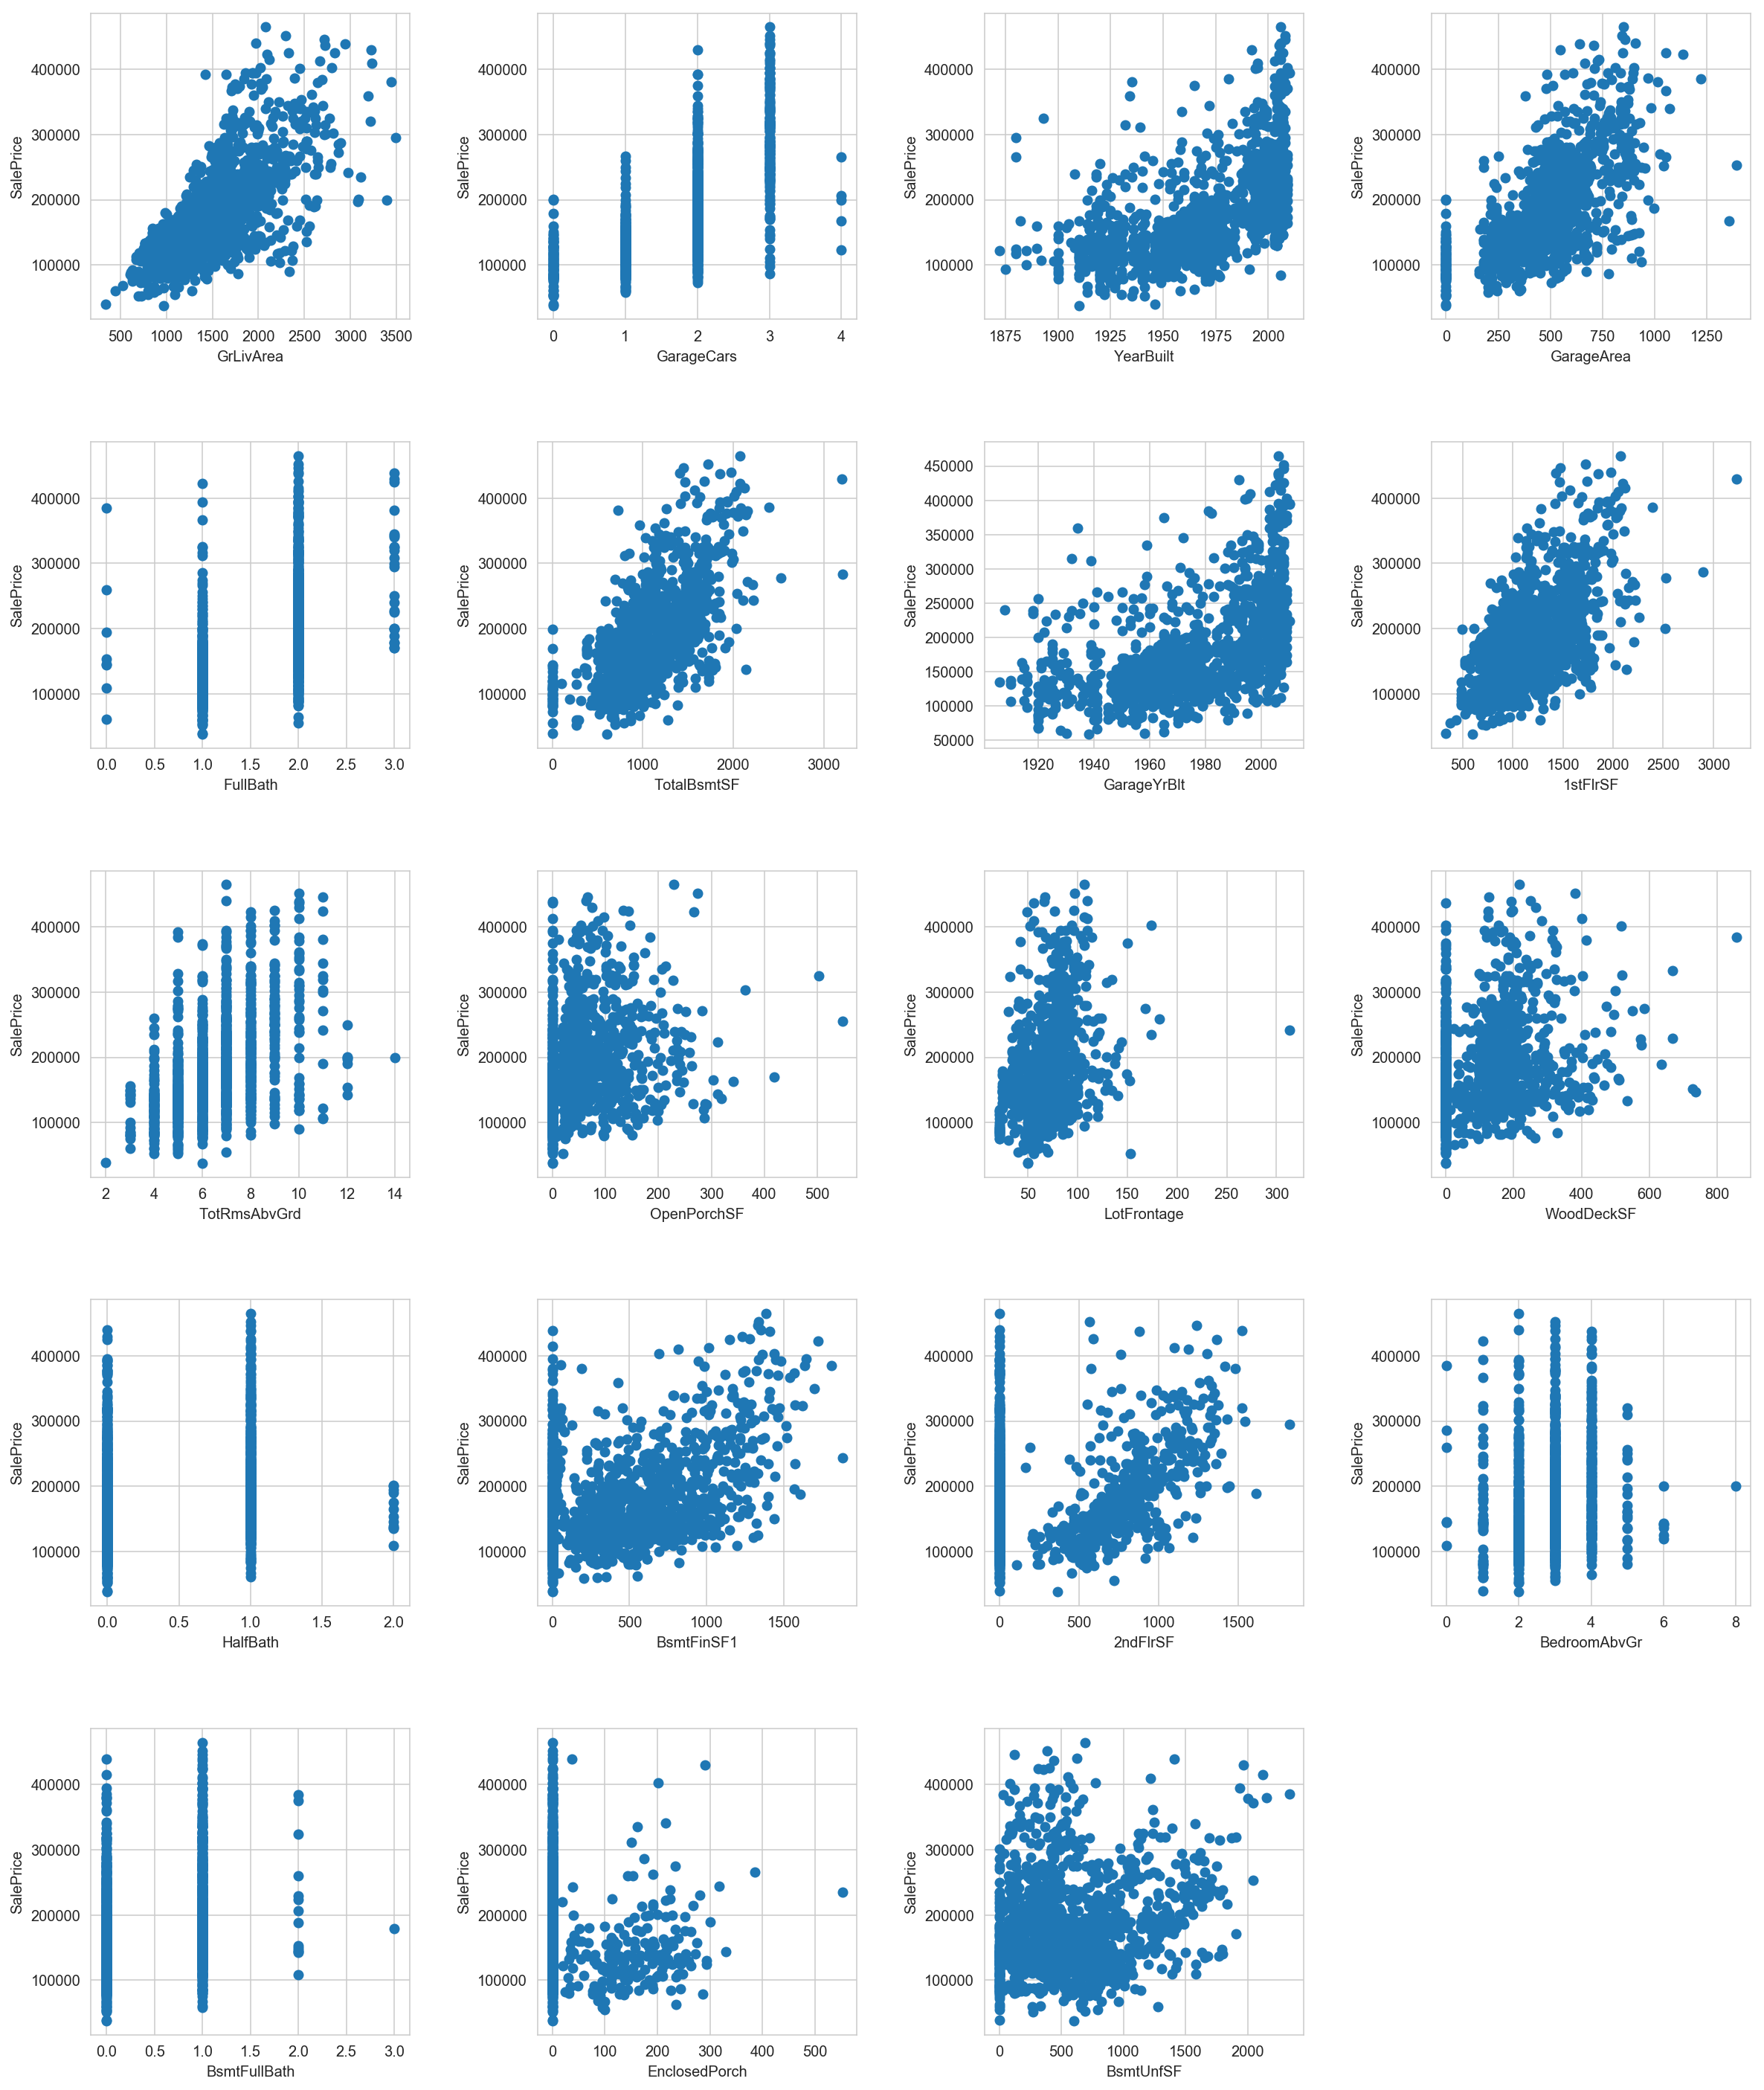

In [24]:
# Plot the first 22 parameters based on Spearman
columns = abs(house_corr.corr(method='spearman')['SalePrice']).sort_values(ascending=False)[1:20].index.values
fig = plt.figure(figsize=(20,25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 20):
    ax = fig.add_subplot(5, 4, i)
    ax.scatter(x=columns[i-1], y='SalePrice', data=house)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('SalePrice')

#### Based on the heatmap, preliminary EDA indicates the following are the 6 features that are significant w.r.t SalePrice.

It provides some sense for us to understand the predictor variables for FIXED feature that will affect SalePrice.

Selection condition :
Pearson/Spearman value > 0.6 ( conservative ):

GrLivArea , GarageCars , YearBuilt, GarageArea , Fullbath , TotalBsmtSF , 1stFlrSF


In [25]:
fixed #total fixed feature
columns # fixed features with continuous variables
fixed_categorical = [ col for col in fixed if col not in columns] #obtain all categorical variables for fixed

#selected feature for continuous fixed based on pearson and spearman
pearson_spearman = ['GrLivArea','GarageCars','YearBuilt','GarageArea','FullBath','TotalBsmtSF','1stFlrSF']

#fixed feature for modelling
fixed_categorical_plus_pearson = fixed_categorical + pearson_spearman
fixed_categorical_plus_pearson

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'Foundation',
 'Functional',
 'KitchenAbvGr',
 'PoolArea',
 'GarageType',
 'ScreenPorch',
 'MiscFeature',
 'MSSubClass',
 '3SsnPorch',
 'BsmtFinSF2',
 'MiscVal',
 'BsmtHalfBath',
 'SalePrice',
 'YrSold',
 'GrLivArea',
 'GarageCars',
 'YearBuilt',
 'GarageArea',
 'FullBath',
 'TotalBsmtSF',
 '1stFlrSF']

### Imputting missing values

In [26]:
#check % data that is null
total=pd.DataFrame({'is_null':house.isnull().sum().sort_values(ascending=False)}) #determine columns with missing values
total['Percentage']= total.is_null/len(house)
total=total[total.is_null!=0]
total

,is_null,Percentage
MiscFeature,1384,0.963788
Alley,1347,0.938022
Fence,1160,0.807799
FireplaceQu,681,0.474234
LotFrontage,258,0.179666
GarageType,79,0.055014
GarageCond,79,0.055014
GarageYrBlt,79,0.055014
GarageFinish,79,0.055014
GarageQual,79,0.055014


In [27]:
total.index #columns that is_null

Index(['MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageType', 'GarageCond', 'GarageYrBlt', 'GarageFinish', 'GarageQual',
       'BsmtExposure', 'BsmtFinType2', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
       'MasVnrArea', 'MasVnrType'],
      dtype='object')

- <b>'MiscFeature'</b> PoolQC nan means it does not have any.Hence, it will be replaced by None.

In [28]:
house.MiscFeature.unique()
house['MiscFeature']=house.MiscFeature.fillna('None')

- <b>'Alley'</b> nan means it does not have any.<br>

In [29]:
house['Alley']=house.Alley.fillna('None')

- <b>'Fence'</b> nan means it does not have any.<br>

In [30]:
house['Fence']=house.Fence.fillna('None')

- <b>'FireplaceQu'</b> nan means it does not have any.<br>

In [31]:
house['FireplaceQu']=house.FireplaceQu.fillna('None')

- <b>'LotFrontage'</b> is a continuous variable. We'd replace nan with median values of the same neighbourhood<br>

In [32]:
house['LotFrontage']=house.groupby('Neighborhood')['LotFrontage'].transform(lambda x : x.fillna(x.median()))

- <b>'GarageCond', 'GarageType','GarageFinish', 'GarageQual'</b> has nan values which means it does not have any Garage. Hence, it will be replaced by None.

In [33]:
for garage in ['GarageCond', 'GarageType','GarageFinish', 'GarageQual']:
    house[garage]=house[garage].fillna('None')

- <b>'GarageYrBlt'</b> has nan values which means it does not have any Garage and it's a continuous variable. 
  Hence, it will be replaced by 0 instead. 

In [34]:
house['GarageYrBlt']=house.GarageYrBlt.fillna(0)

- <b>'BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1'</b> has nan values which means it does not have any Basement. Hence, it will be replaced by None. 

In [35]:
for basement in ['BsmtExposure', 'BsmtFinType2', 'BsmtCond', 'BsmtQual', 'BsmtFinType1']:
    house[basement]=house[basement].fillna('None')

- <b>'MasVnrArea' ,'MasVnrType'</b> has nan values which means it does not have any external Masonry Veneer.<br>
Hence, 'MasVnrArea' will be replaced by 0.<br>
'MasVnrType'will be replaced by None.<br><br>
More about Masonry Veneer http://pdf.archiexpo.com/pdf/sto-ag/stoenergy-guard-adhere-masonry-veneer-sell-sheet-s841/56990-228563.html

In [36]:
house['MasVnrArea']=house.MasVnrArea.fillna('0')
house['MasVnrType']=house.MasVnrType.fillna('None')
house.isnull().sum().sort_values(ascending=False)#all columns are cleaned

SalePrice        0
Foundation       0
RoofMatl         0
Exterior1st      0
Exterior2nd      0
MasVnrType       0
MasVnrArea       0
ExterQual        0
ExterCond        0
BsmtQual         0
YearRemodAdd     0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
BsmtFinSF1       0
BsmtFinType2     0
BsmtFinSF2       0
BsmtUnfSF        0
RoofStyle        0
YearBuilt        0
SaleCondition    0
Utilities        0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
Alley            0
LotShape         0
LandContour      0
LotConfig        0
                ..
EnclosedPorch    0
ScreenPorch      0
CentralAir       0
PoolArea         0
Fence            0
MiscFeature      0
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
GarageCars       0
GarageFinish     0
GarageYrBlt      0
GarageType       0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath    

In [37]:
house.Utilities.value_counts() # drop this because contribution to the target is very similar as there is only 1 NoSewa
house.drop('Utilities',axis=1,inplace=True)

## Modelling

In [38]:
#Feature engineering
#Add total area of house
house['TotalSF'] = house['TotalBsmtSF'] + house['1stFlrSF'] + house['2ndFlrSF']

#Add to the fixed feature selection for modelling
fixed_final = fixed_categorical_plus_pearson + ['TotalSF']

In [39]:
house_final = house.copy() #this is the final copy after cleaning, take note

In [40]:
# Create dummy variables for all categorical columns.
df = house_final[fixed_final]

def ohe(df):
    '''
    get_dummies are created by just providing the DataFrame
    continuous variables will not be ohe-ed
    remember to include your dependent variable too
    function will returned an EXPLODED dataframe
    '''    
    #cycle through all the columns at the df
    for col in df.columns:
        #if col if it's an object, get_dummy on it and concat to a df
        if col in df.select_dtypes('object').columns.values: 
            dummy = pd.get_dummies(df[col], drop_first=True, prefix=col,dtype=int)
            df = pd.concat([df, dummy], axis=1)
            #drop the col after it has been encoded
            df.drop(col, axis=1, inplace=True)
    return df

df=ohe(df)

#need to reset the index for cross_val to work correctly since some rows are droppped
df.reset_index(inplace=True) 
df.shape

(1436, 121)

In [41]:
# This list of column names will come in handy later ( for RFECV ).
cols = list(df.columns)
cols.remove('SalePrice')

df.YrSold.unique()

array([2008, 2007, 2006, 2009, 2010], dtype=int64)

In [42]:
#Create Train and Test set based on YrSold 2010
X_train = df.query('YrSold < 2010').drop(['SalePrice'],axis=1)
y_train = df.query('YrSold < 2010')['SalePrice']
X_test  = df.query('YrSold == 2010').drop(['SalePrice'],axis=1)
y_test  = df.query('YrSold == 2010')['SalePrice']

In [43]:
# normalise X_train and X_test
ss=StandardScaler()
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.transform(X_test)

In [44]:
# Multiple Linear Regression is applied to the Training set
# This model is to have a general feel of what will happpen without any regularisation 
#
# Cross validation is very inconsistent(negative) 
# Hence, we need to perform feature selection to make our model more robust

from sklearn.linear_model import LinearRegression
lr = LinearRegression()

## Calculating cross-validation scores
from sklearn.model_selection import cross_val_score
lr_scores = cross_val_score(lr, X_train_std, y_train, cv=10)
print('Cross val score:{}'.format(lr_scores))
print('Cross val score mean:{}'.format(np.mean(lr_scores)))
print('Cross-val scores std dev:{}'.format(np.std(lr_scores)))
#print("Cross val R^2:{}".format(r2_score(y_test,y_pred)))

Cross val score:[ 8.72136837e-01  8.66470372e-01 -1.60268605e+23  8.34592562e-01
 -3.29262659e+22 -5.02608645e+23 -2.18096867e+24  8.31458812e-01
  7.96509918e-01 -2.35063990e+20]
Cross val score mean:-2.877007249473256e+23
Cross-val scores std dev:6.487135683111731e+23


In [45]:
X_train.shape

(1266, 120)

In [46]:
#RFECV is used for feature selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_train_std, y_train)

print(selector.support_)
print(selector.ranking_)

rfecv_columns = np.array(cols)[selector.support_]
rfecv_columns

[False  True False False False False False False False False  True  True
  True False  True  True  True False False False False False False False
 False False  True  True False False False False False False False False
 False  True False False  True False False False False False False False
 False  True  True False False False False  True  True False  True False
  True False False False False False False False False  True False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False  True
  True False  True False  True  True False False False False  True False
 False  True  True False False False False False False False False False]
[36  1 16 14 30 91 10 60 73 76  1  1  1 49  1  1  1 48 46 47 65 68 69 25
 57 93  1  1 67  5 59 66 89 43 90 64 11  1 56 78  1 77 26 86 81 17 74 51
 15  1  1 87 61 75 79  1  1  6  1 44  1 52 37 63 27 88 45 70 54  1 53 35
 94 55 42 50 41 18 23  1 58 62 83 21 84 72 31 71 9

array(['KitchenAbvGr', 'GarageCars', 'YearBuilt', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'TotalSF', 'LandContour_HLS',
       'LandContour_Low', 'Neighborhood_BrkSide', 'Neighborhood_Crawfor',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Neighborhood_Veenker', 'Condition1_Norm', 'Condition2_PosA',
       'HouseStyle_1Story', 'Functional_Typ', 'GarageType_Attchd',
       'GarageType_BuiltIn', 'GarageType_Detchd', 'GarageType_None',
       'MSSubClass_160', 'MSSubClass_20', 'MSSubClass_30'], dtype='<U20')

In [47]:
#391 features has shrank to 27 due to feature selection(RFECV)
len(rfecv_columns)

27

<br>- It seems like RFECV agrees mostly with Pearson/Spearman with the features selection.<br>
GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt
<br>- Feature that is engineered, TotalSF , is selected which means it's significant
<br>- Also to note almost half of the 'Neighbours' features are selected means location is significant.

In [48]:
#Re-create Train and Test set based on feature that are selected by RFECV

X_train = df.query('YrSold < 2010')[rfecv_columns]
y_train = df.query('YrSold < 2010')['SalePrice']
X_test  = df.query('YrSold == 2010')[rfecv_columns]
y_test  = df.query('YrSold == 2010')['SalePrice']

# normalise X_train and X_test
ss=StandardScaler()
X_train_std=ss.fit_transform(X_train)
X_test_std=ss.transform(X_test)

In [49]:
# keep this for Q2
# we will be using this for imputting the actual sale - pred sale

train_index = X_train.index
test_index = X_test.index

Cross-validation scores:[0.86373904 0.87824581 0.88223049 0.83498791 0.82351965 0.86139124
 0.83769438 0.82905864 0.80756574 0.83059482]
Cross-validation scores mean:0.844902772174699
Cross-validation scores std dev:0.02364128283538205
cross-val R^2:0.8622176123853265


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


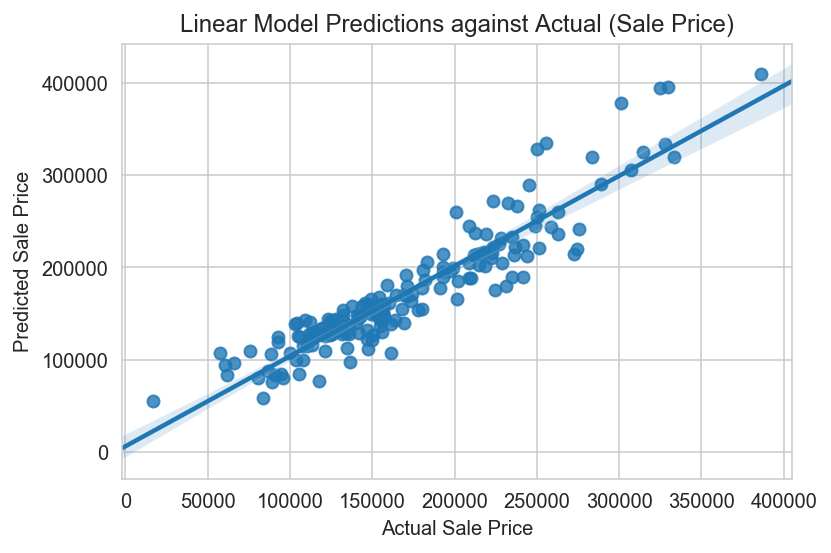

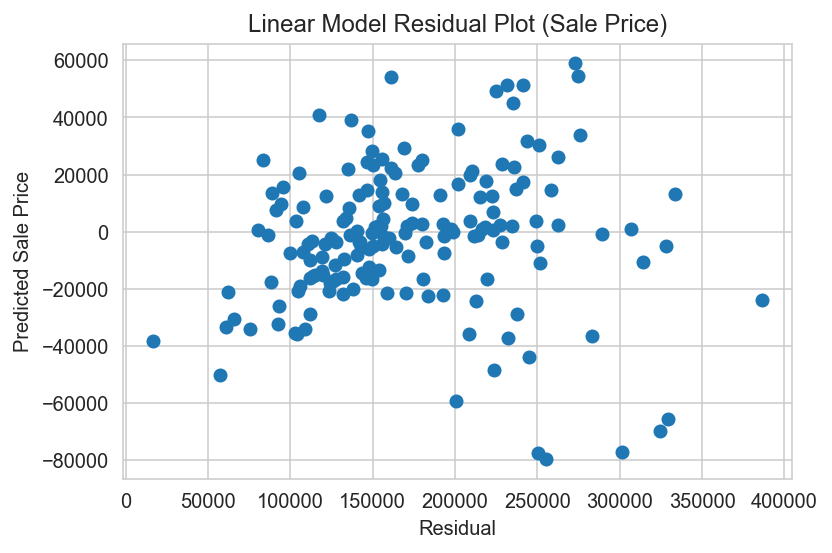

,features,coefficient,abs coefficient
6,TotalSF,44258.695484,44258.695484
2,YearBuilt,15436.986329,15436.986329
4,TotalBsmtSF,-15008.586683,15008.586683
12,Neighborhood_NridgHt,12792.122666,12792.122666
18,HouseStyle_1Story,-10008.883752,10008.883752
20,GarageType_Attchd,9071.914504,9071.914504
5,1stFlrSF,8367.176072,8367.176072
0,KitchenAbvGr,-7324.098424,7324.098424
22,GarageType_Detchd,7287.905143,7287.905143
25,MSSubClass_20,6972.408748,6972.408748


In [50]:
# We will be re-training all our 3 models based on features selected by RFECV

# Fit Multiple Linear Regression to Training Set 
lr2 = LinearRegression()

# Fit model
lr2.fit(X_train_std, y_train)

# Calculate cross-validation scores
from sklearn.model_selection import cross_val_score
lr2_scores = cross_val_score(lr2, X_train_std, y_train, cv=10)

print('Cross-validation scores:{}'.format(lr2_scores))
print('Cross-validation scores mean:{}'.format(np.mean(lr2_scores)))
print('Cross-validation scores std dev:{}'.format(np.std(lr2_scores)))

# Predict Test set
y_pred = lr2.predict(X_test_std)

# Calculate R-squared
from sklearn.metrics import r2_score
print("cross-val R^2:{}".format(r2_score(y_test,y_pred)))

# Plot predicted values against actual values to find correlation
sns.regplot(y_pred,y_test)
plt.title('Linear Model Predictions against Actual (Sale Price)')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

# Plot Residual to eval co-relation
plt.scatter(y_pred,(y_pred-y_test))
plt.title('Linear Model Residual Plot (Sale Price)')
plt.xlabel('Residual')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create dataframe of coefficients
results = pd.DataFrame()
results['features'] = X_train.columns
results['coefficient'] = lr2.coef_
results['abs coefficient'] = np.abs(lr2.coef_)
results.sort_values(by='abs coefficient',ascending=False)

The score is definitely better after we did feature selection.
Cross val score is consistent and 2(YearBuilt,TotalBsmtSF) out of 7 of the co-related features appeared in the top 10.

Cross-validation scores:[0.86212611 0.87769878 0.88175163 0.83597525 0.82200132 0.86271388
 0.83727826 0.82960469 0.80821012 0.83154205]
Cross-validation scores mean:0.8448902088462914
Cross-validation scores std dev:0.02338481290597317
cross-val R^2:0.8633889923430618


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


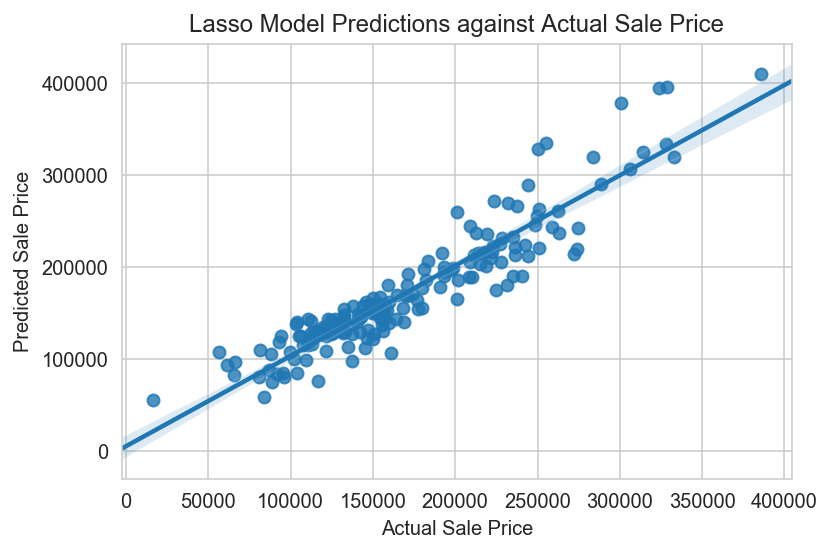

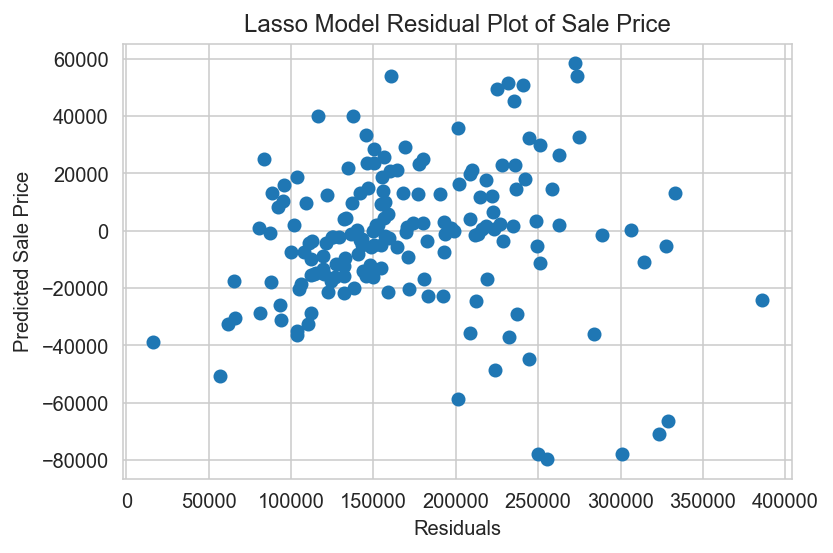

Percent variables zero-ed : 0.0
Number of variables zero-ed : 0


,features,coefficient,abs coefficient
6,TotalSF,44183.495464,44183.495464
2,YearBuilt,15206.462486,15206.462486
4,TotalBsmtSF,-14413.451211,14413.451211
12,Neighborhood_NridgHt,12699.984215,12699.984215
18,HouseStyle_1Story,-9403.631024,9403.631024
5,1stFlrSF,7867.774834,7867.774834
0,KitchenAbvGr,-7396.363736,7396.363736
20,GarageType_Attchd,7130.466581,7130.466581
1,GarageCars,6760.821908,6760.821908
14,Neighborhood_StoneBr,6561.254745,6561.254745


In [51]:
# Lasso fitted to the Training set

from sklearn.linear_model import Lasso, LassoCV

optimal_lassof = LassoCV(n_alphas=1000, cv=10)
optimal_lassof.fit(X_train_std, y_train)

lassof = Lasso(alpha=optimal_lassof.alpha_)
lassof.fit(X_train_std, y_train)

## Calculate cross-validation scores
from sklearn.model_selection import cross_val_score
lassof_scores = cross_val_score(lassof, X_train_std, y_train, cv=10)
print('Cross-validation scores:{}'.format(lassof_scores))
print('Cross-validation scores mean:{}'.format(np.mean(lassof_scores)))
print('Cross-validation scores std dev:{}'.format(np.std(lassof_scores)))

# Predict the Test set results
y_predl = lassof.predict(X_test_std)

# Calculate R^2
from sklearn.metrics import r2_score
print("cross-val R^2:{}".format(r2_score(y_test,y_predl)))

# Plot predicted values against actual values to find correlation
sns.regplot(y_predl,y_test)
plt.title('Lasso Model Predictions against Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

#Plot residual plot
plt.scatter(y_predl,(y_predl-y_test))
plt.title('Lasso Model Residual Plot of Sale Price')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create df for coefficients
results_lasso = pd.DataFrame()
results_lasso['features'] = X_train.columns
results_lasso['coefficient'] = lassof.coef_
results_lasso['abs coefficient'] = np.abs(lassof.coef_)


# Percentage that are zero-ed out
print('Percent variables zero-ed :', np.sum((lassof.coef_ == 0))/(float(len(lassof.coef_))*100))
print('Number of variables zero-ed :', (results_lasso['abs coefficient']==0).sum())

results_lasso.sort_values(by='abs coefficient',ascending=False)


Lasso model has also 3 corelated features ( GarageCars,YearBuilt and TotalBsmtSF) that made it in the top 10 . R2 score is very similar as compared to MLP. No feature is elimininated as the important ones are being filtered by RFECV.

Cross-validation scores:[0.8632949  0.87760299 0.88163253 0.8348912  0.82318582 0.86212831
 0.83779038 0.82971569 0.80880676 0.83137488]
Cross-validation scores mean:0.8450423462281703
Cross-validation scores std dev:0.023221092186681773
cross-val R^2:0.863132612343284


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


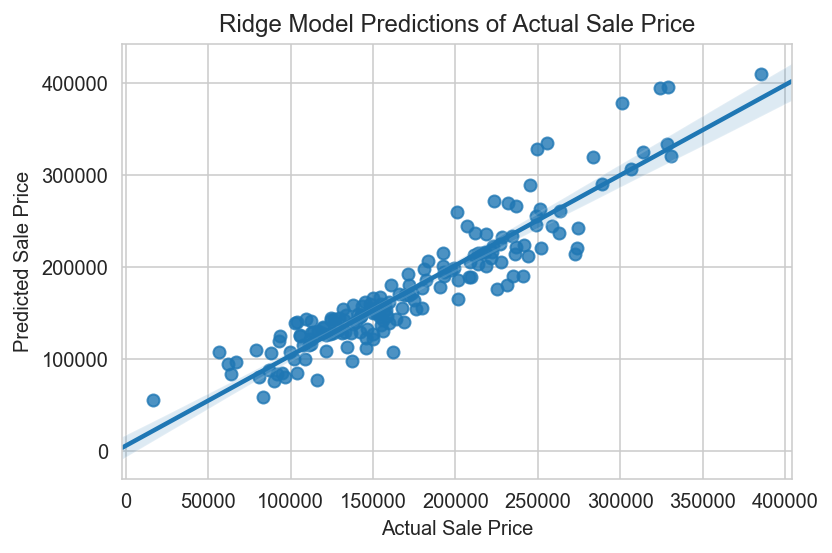

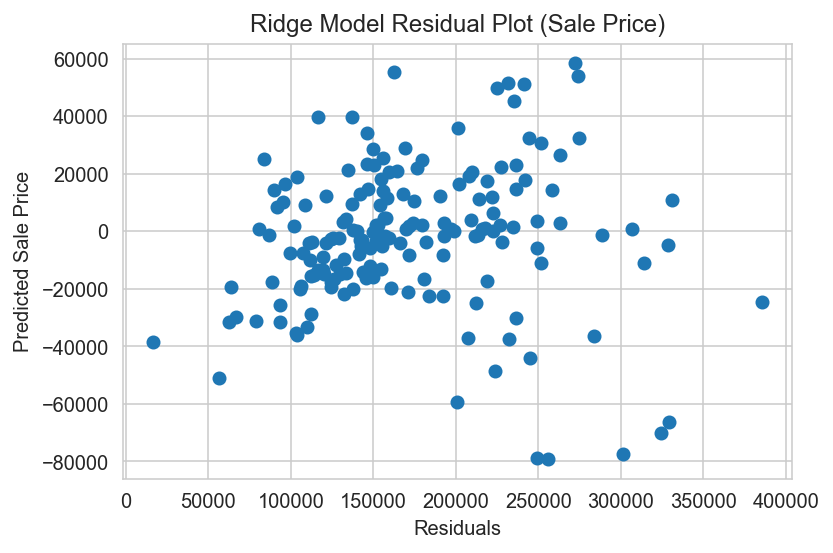

,features,coefficient,abs coefficient
6,TotalSF,42457.019906,42457.019906
2,YearBuilt,15108.403417,15108.403417
4,TotalBsmtSF,-13573.102568,13573.102568
12,Neighborhood_NridgHt,12709.741868,12709.741868
18,HouseStyle_1Story,-10313.755645,10313.755645
5,1stFlrSF,8723.498570,8723.498570
20,GarageType_Attchd,8267.181404,8267.181404
0,KitchenAbvGr,-7304.480778,7304.480778
1,GarageCars,6940.489592,6940.489592
14,Neighborhood_StoneBr,6619.752574,6619.752574


In [52]:
# Ridge Regression fitted to the Training set

from sklearn.linear_model import Ridge, RidgeCV

ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_train_std, y_train)

ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train_std, y_train)

## Calculate cross-validation scores
ridge_scores = cross_val_score(ridge, X_train_std, y_train, cv=10)
print('Cross-validation scores:{}'.format(ridge_scores))
print('Cross-validation scores mean:{}'.format(np.mean(ridge_scores)))
print('Cross-validation scores std dev:{}'.format(np.std(ridge_scores)))

# Predicting the Test result
y_predr = ridge.predict(X_test_std)

## Calculate R-squared
print("cross-val R^2:{}".format(r2_score(y_test,y_predr)))

## Plot predicted values against actual values to eval correlation
sns.regplot(y_predr,y_test)
plt.title('Ridge Model Predictions of Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

## Plot predicted values against actual values to eval correlation
plt.scatter(y_predr,(y_predr - y_test))
plt.title('Ridge Model Residual Plot (Sale Price)')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create df for coefficients
results_ridge = pd.DataFrame()
results_ridge['features'] = X_train.columns
results_ridge['coefficient'] = ridge.coef_
results_ridge['abs coefficient'] = np.abs(ridge.coef_)
results_ridge.sort_values(by='abs coefficient',ascending=False)

For ridge, 3(GarageCars,YearBuilt,TotalBsmtSF) out of 6 co-related features came out at the top ten of the co-efficients. One of the location(Neighborhood_NridgHt) also played a part as well too.

### Conclusion

- Overall all the models post RFECV have similar R2 Score and Std Deviation score. 
- Lasso Model is selected because it has a slightly better R^2 and std_dev score.
- Besides, Lasso is able to regularise the models such that it is able to overfit less and hence it's more robust/generalised. 
- There's not much of impact for Lasso's ability to zero some of features as RCEFV did a good job on this.

- The Engineered feature TotalSF ( Total Square Feet of the house ) turns out to be the most significant feature of all as
as expected buyers would want a big house.

- The later the House is built, the more costly is the house.

- Houses at the NridgHt neighborhood seems to fetch a highest price. Followed by StoneBr,Somerst and Crawfor. 
Coefficient of NrighHt is twice the figure of Crawfor. We do not stay in Ames but based on domain knowledge here, location 
plays a very important part.

- MSSUbClass of 60,2-STORY 1946 & NEWER are the most preferred type of property as the design is more modern
and most residents would like to have privacy at the 2nd level.

- Buyers are not fond of basement and upon research one needs to maitain the basement hence it's less attractive. https://www.mansionglobal.com/articles/why-a-basement-can-hurt-the-price-of-a-luxury-home-15317

- MSSubClass_160 2-STORY PUD - 1946 & NEWER will affect the price negatively because there is also maintenance fees involved and there's no 'persnal garage' available. http://www.city-data.com/forum/los-angeles/617843-what-pud-home.html 

- Last but not least ,a Garage is very important as most American own a car.


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [53]:
# Predict the Training and Test set results with Ridge
y_pred_train= list(ridge.predict(X_train_std)) #train
y_pred_test = list(ridge.predict(X_test_std)) #test

# Predict the Training and Test set results with Lasso
y_pred_train_l= list(lassof.predict(X_train_std)) #train
y_pred_test_l = list(lassof.predict(X_test_std)) #test

In [54]:
#create new df starting point for Q2
#all important columns for renovatable is included less the FIXED columns at Q1
house2=house_final[reno_all]

In [55]:
#Drop Fence as it has a lot of null values
house2.Fence.value_counts()

None     1160
MnPrv     154
GdPrv      58
GdWo       53
MnWw       11
Name: Fence, dtype: int64

In [56]:
house2.drop('Fence',axis=1,inplace=True)

In [57]:
# obtain the index for train and test index 
train_index = X_train.index
test_index = X_test.index

In [58]:
#imput the y_pred values accordingly to the new df for Ridge
house2.loc[house2.index[train_index], 'sale_pred'] = y_pred_train
house2.loc[house2.index[test_index], 'sale_pred'] = y_pred_test
house2['residual']=house2.SalePrice - house2.sale_pred 
house2.sale_pred.isnull().sum() # all values , imputted

#imput the y_pred values accordingly to the new df for Lasso
house2.loc[house2.index[train_index], 'sale_pred_lasso'] = y_pred_train_l
house2.loc[house2.index[test_index], 'sale_pred_lasso'] = y_pred_test_l
house2['residual_lasso']=house2.SalePrice - house2.sale_pred_lasso
house2.sale_pred.isnull().sum() # all values , imputted


0

In [59]:
#obtain columns that has grading characteristics that we can map to numbers
house2['ExterQual'].unique()

array(['Gd', 'TA', 'Ex', 'Fa'], dtype=object)

In [60]:
house2.columns

Index(['OverallQual', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'OverallCond', 'YrSold',
       'SalePrice', 'Fireplaces', 'MasVnrArea', 'LowQualFinSF', 'sale_pred',
       'residual', 'sale_pred_lasso', 'residual_lasso'],
      dtype='object')

In [61]:
'TA' in house2['ExterQual'].values

True

In [62]:
quality_col = [ col for col in house2.columns if 'TA' in house2[col].values ]
quality_col

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


['ExterQual',
 'ExterCond',
 'BsmtCond',
 'HeatingQC',
 'BsmtQual',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond']

In [63]:
#value replacement based on the following mapping, 
#NA will be replaced by -1 since it's not applicable

quality_mapping = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'None':-1}

for col in quality_col:
    house2[col] = house2[col].map(quality_mapping)

In [64]:
#drop these 2 cols as it's not required already
house2.drop(['sale_pred','sale_pred_lasso'],axis=1,inplace=True)

In [65]:
house2.columns

Index(['OverallQual', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'OverallCond', 'YrSold',
       'SalePrice', 'Fireplaces', 'MasVnrArea', 'LowQualFinSF', 'residual',
       'residual_lasso'],
      dtype='object')

In [66]:
cont=house2.dtypes[house2.dtypes!='object'].index 
cont

Index(['OverallQual', 'YearRemodAdd', 'ExterQual', 'ExterCond', 'BsmtCond',
       'HeatingQC', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'GarageQual',
       'GarageCond', 'OverallCond', 'YrSold', 'SalePrice', 'Fireplaces',
       'LowQualFinSF', 'residual', 'residual_lasso'],
      dtype='object')

In [67]:
house2.drop(columns=['residual_lasso','SalePrice'],axis=1).corr(method='spearman')['residual'].sort_values(ascending=False)

residual        1.000000
OverallCond     0.268738
KitchenQual     0.134677
YearRemodAdd    0.131079
OverallQual     0.094952
HeatingQC       0.093864
ExterQual       0.079833
FireplaceQu     0.062782
Fireplaces      0.061291
ExterCond       0.056962
YrSold          0.041591
GarageCond      0.031000
BsmtCond        0.028316
GarageQual      0.027630
BsmtQual        0.011352
LowQualFinSF   -0.004614
Name: residual, dtype: float64

house2.drop(columns=['Fireplaces', 'FireplaceQu','OverallQual','KitchenQual','ExterQual',
                     'LowQualFinSF','YearRemodAdd','GarageQual','GarageCond','HeatingQC','BsmtQual',
                     'BsmtCond','ExterCond'],axis=1,inplace=True)

In [68]:
# Define a function which take a dataframe and column as input and returns number of unique values in that columns 
def select_feature(df, col):
   max_count = df[col].value_counts().max()
   return float(max_count)/df.shape[0]

In [69]:
feature_props = [[col,select_feature(house2, col)] for col in house2.columns]
feature_props = pd.DataFrame(feature_props, columns=['feature','majority'])
feature_props_remove_cols = feature_props[feature_props.majority > 0.95].feature.values
#new_df2 = df2.drop(feature_props_remove_cols, axis=1)

print(feature_props_remove_cols)

['RoofMatl' 'Heating' 'LowQualFinSF']


In [70]:
house2.drop(columns=feature_props_remove_cols,axis=1,inplace=True)

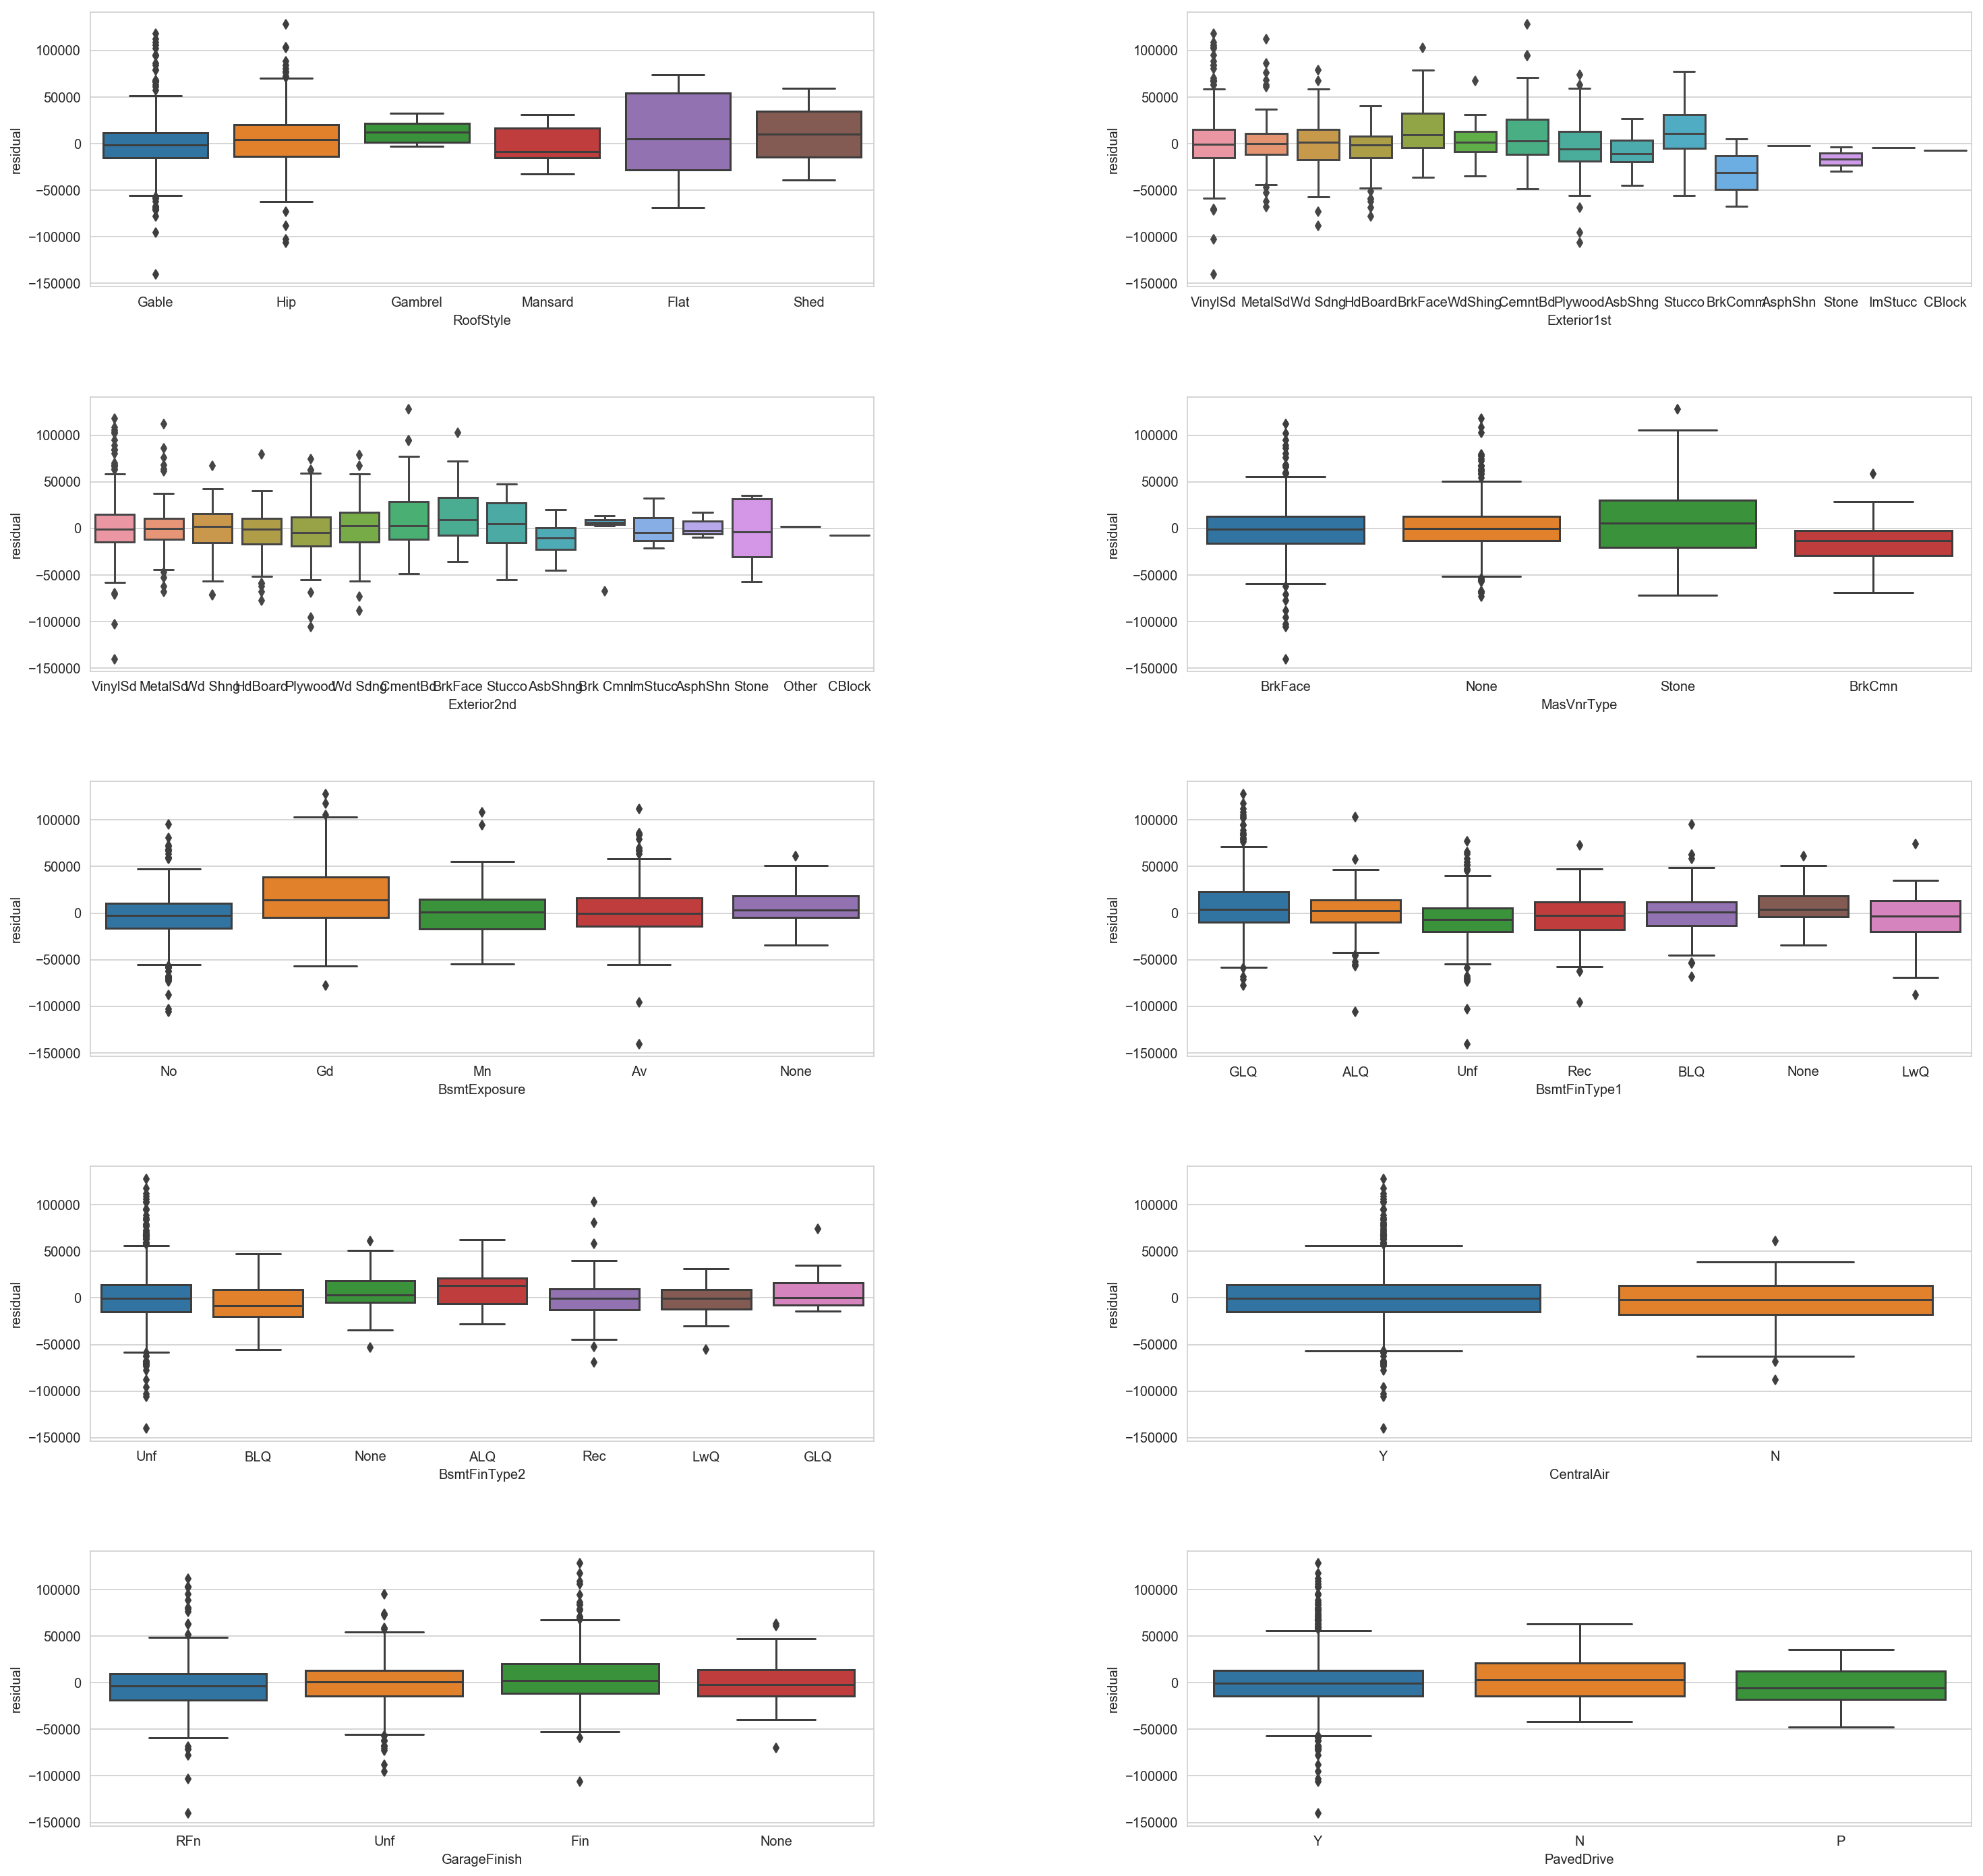

In [71]:
# Plot all the categorical columns to check variance
# all features seems ok to keep
columns = house2.dtypes[house2.dtypes=='object'].index
fig = plt.figure(figsize=(25,30))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(1, 11):
    ax = fig.add_subplot(6, 2, i)
    ax = sns.boxplot(x=columns[i-1], y="residual", data=house2)
    #ax.scatter(x=columns[i-1], y='residual', data=house2)
    ax.set_xlabel(columns[i-1])
    ax.set_ylabel('residual')

In [72]:
#Perform One Hot Encoding 
reno=ohe(house2) 

In [73]:
reno.shape

(1436, 394)

In [74]:
#Create Train and Test set for Ridge

X_train = reno.query('YrSold < 2010').drop(columns=['residual','residual_lasso','SalePrice'],axis=1)
y_train = reno.query('YrSold < 2010').drop('SalePrice',axis=1)['residual']
X_test  = reno.query('YrSold == 2010').drop(columns=['residual','residual_lasso','SalePrice'],axis=1)
y_test  = reno.query('YrSold == 2010').drop('SalePrice',axis=1)['residual']


# will not normalise X_train and X_test

Cross-validation scores:[0.13662598 0.13687562 0.20701907 0.27519321 0.22131277 0.12312842
 0.05670099 0.13066317 0.24983026 0.1696665 ]
Cross-validation scores mean:0.17070159951242272
Cross-validation scores std dev:0.06342643691991877
cross-val R^2:0.1353106862687512


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


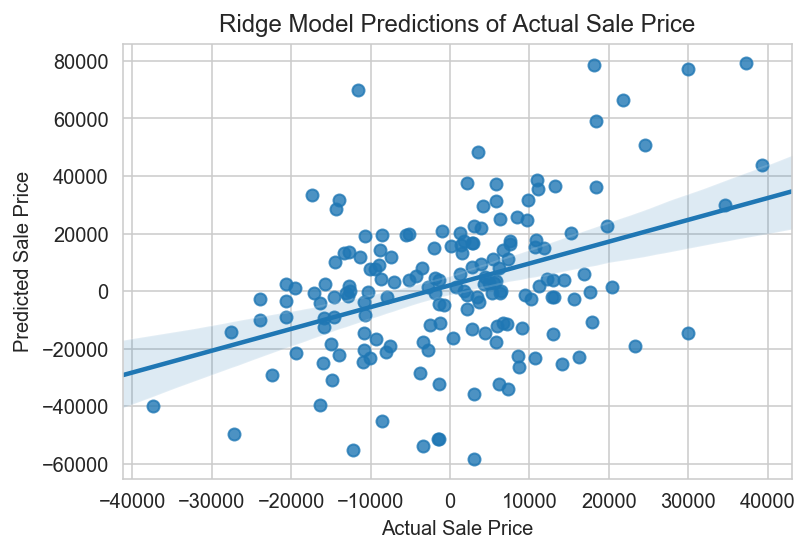

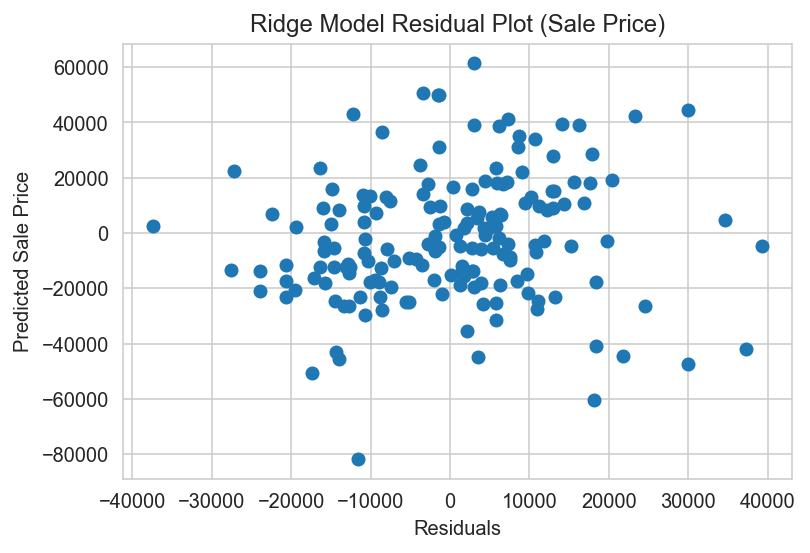

,features,coefficient,abs coefficient
322,MasVnrArea_428.0,-19523.042761,19523.042761
317,MasVnrArea_420.0,14633.372072,14633.372072
240,MasVnrArea_256.0,-14464.258326,14464.258326
195,MasVnrArea_186.0,14438.500179,14438.500179
209,MasVnrArea_209.0,-13559.389718,13559.389718
273,MasVnrArea_304.0,13317.015716,13317.015716
51,BsmtExposure_Gd,12993.168528,12993.168528
134,MasVnrArea_106.0,-12627.363183,12627.363183
236,MasVnrArea_250.0,-11939.873077,11939.873077
174,MasVnrArea_160.0,11539.603859,11539.603859


In [75]:
# Ridge Regression fitted to the Training set

from sklearn.linear_model import Ridge, RidgeCV

ridge_alphas = np.logspace(-2, 7, 50)
optimal_ridge_reno = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge_reno.fit(X_train, y_train)

ridge_reno = Ridge(alpha=optimal_ridge.alpha_)
ridge_reno.fit(X_train, y_train)

## Calculate cross-validation scores
ridge_scores_reno = cross_val_score(ridge_reno, X_train, y_train, cv=10)
print('Cross-validation scores:{}'.format(ridge_scores_reno))
print('Cross-validation scores mean:{}'.format(np.mean(ridge_scores_reno)))
print('Cross-validation scores std dev:{}'.format(np.std(ridge_scores_reno)))

# Predicting the Test result
y_predr_reno = ridge_reno.predict(X_test)

## Calculate R-squared
print("cross-val R^2:{}".format(r2_score(y_test,y_predr_reno)))

## Plot predicted values against actual values to eval correlation
sns.regplot(y_predr_reno,y_test)
plt.title('Ridge Model Predictions of Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

## Plot predicted values against actual values to eval correlation
plt.scatter(y_predr_reno,(y_predr_reno - y_test))
plt.title('Ridge Model Residual Plot (Sale Price)')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create df for coefficients
results_ridge = pd.DataFrame()
results_ridge['features'] = X_train.columns
results_ridge['coefficient'] = ridge_reno.coef_
results_ridge['abs coefficient'] = np.abs(ridge_reno.coef_)
results_ridge.sort_values(by='abs coefficient',ascending=False)

In [76]:
#Create Train and Test set for Lasso

X_train = reno.query('YrSold < 2010').drop(columns=['residual','residual_lasso','SalePrice'],axis=1)
y_train = reno.query('YrSold < 2010').drop('SalePrice',axis=1)['residual_lasso']
X_test  = reno.query('YrSold == 2010').drop(columns=['residual','residual_lasso','SalePrice'],axis=1)
y_test  = reno.query('YrSold == 2010').drop('SalePrice',axis=1)['residual_lasso']


# will not normalise X_train and X_test

Cross-validation scores:[0.0999614  0.15447578 0.21838161 0.29241009 0.22124331 0.08459055
 0.02344361 0.11671407 0.27545211 0.17463793]
Cross-validation scores mean:0.16613104555899683
Cross-validation scores std dev:0.08228134725552469
cross-val R^2:0.15861785172160814


C:\Users\andre\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


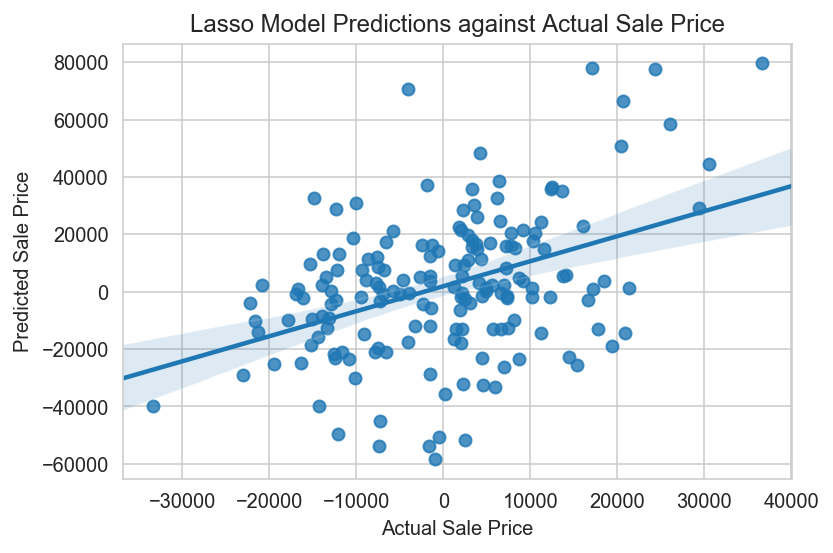

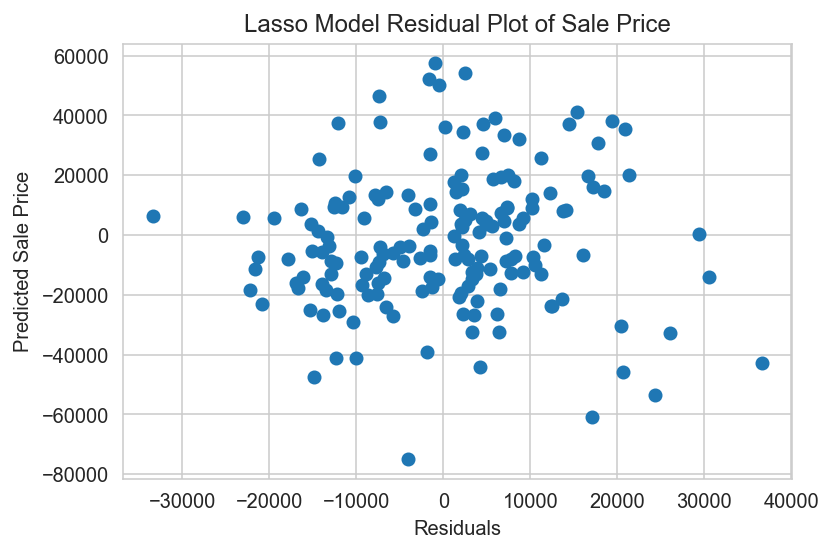

Percent variables zero-ed : 91.81585677749361
Number of variables zero-ed : 359


,features,coefficient,abs coefficient
51,BsmtExposure_Gd,12800.282014,12800.282014
21,Exterior1st_BrkFace,10088.912901,10088.912901
60,BsmtFinType1_Unf,-8164.395185,8164.395185
11,OverallCond,6986.805935,6986.805935
69,GarageFinish_RFn,-5732.828563,5732.828563
3,ExterCond,-4774.357149,4774.357149
56,BsmtFinType1_GLQ,3549.462836,3549.462836
2,ExterQual,3334.854663,3334.854663
38,Exterior2nd_HdBoard,-3083.081819,3083.081819
4,BsmtCond,-3055.803108,3055.803108


In [77]:
# Lasso fitted to the Training set

from sklearn.linear_model import Lasso, LassoCV

optimal_lassof = LassoCV(n_alphas=1000, cv=10)
optimal_lassof.fit(X_train, y_train)

lasso_reno = Lasso(alpha=optimal_lassof.alpha_)
lasso_reno.fit(X_train, y_train)

## Calculate cross-validation scores
from sklearn.model_selection import cross_val_score
lasso_reno_scores = cross_val_score(lassof, X_train, y_train, cv=10)
print('Cross-validation scores:{}'.format(lasso_reno_scores))
print('Cross-validation scores mean:{}'.format(np.mean(lasso_reno_scores)))
print('Cross-validation scores std dev:{}'.format(np.std(lasso_reno_scores)))

# Predict the Test set results
y_predl = lasso_reno.predict(X_test)

# Calculate R^2
from sklearn.metrics import r2_score
print("cross-val R^2:{}".format(r2_score(y_test,y_predl)))

# Plot predicted values against actual values to find correlation
sns.regplot(y_predl,y_test)
plt.title('Lasso Model Predictions against Actual Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.show()

#Plot residual plot
plt.scatter(y_predl,(y_predl-y_test))
plt.title('Lasso Model Residual Plot of Sale Price')
plt.xlabel('Residuals')
plt.ylabel('Predicted Sale Price')
plt.show()

# Create df for coefficients
results_lasso = pd.DataFrame()
results_lasso['features'] = X_train.columns
results_lasso['coefficient'] = lasso_reno.coef_
results_lasso['abs coefficient'] = np.abs(lasso_reno.coef_)

# Percentage that are zero-ed out
print('Percent variables zero-ed :', np.sum((lasso_reno.coef_ == 0)*100)/(float(len(lasso_reno.coef_))))
print('Number of variables zero-ed :', (results_lasso['abs coefficient']==0).sum())

results_lasso.sort_values(by='abs coefficient',ascending=False)

Comparatively, lasso has a better R^2 score as compared to ridge.
Hence, when 'fixed' and 'renovatable & residual' are both taken into consideration, Lasso should be chosen.
Also, lasso managed to zero-ed 359( 92% ) more variables that has multi-colinearity.



In [78]:
#re-construct the dataframe with the predicted residual values
#Calculate 'SalePrice_reno' = Actual Sale Price - Predicted Residual
y_predr_reno_train = list(ridge_reno.predict(X_train))
y_predr_reno_test = list(ridge_reno.predict(X_test))

house2.loc[house2.index[train_index], 'residual_predicted'] = y_predr_reno_train
house2.loc[house2.index[test_index], 'residual_predicted'] = y_predr_reno_test

house2['SalePrice_reno']=house2.SalePrice - house2.residual_predicted 

In [79]:
house2.drop('residual_lasso',axis=1).head()

,OverallQual,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,BsmtCond,BsmtExposure,...,GarageCond,PavedDrive,OverallCond,YrSold,SalePrice,Fireplaces,MasVnrArea,residual,residual_predicted,SalePrice_reno
0,7,2003,Gable,VinylSd,VinylSd,BrkFace,3,2,2,No,...,2,Y,5,2008,208500,0,196,8944.385134,-4494.786706,212994.786706
1,6,1976,Gable,MetalSd,MetalSd,None,2,2,2,Gd,...,2,Y,8,2007,181500,1,0,-23595.484972,28645.813051,152854.186949
2,7,2002,Gable,VinylSd,VinylSd,BrkFace,3,2,2,Mn,...,2,Y,5,2008,223500,1,162,16166.422148,12141.094657,211358.905343
3,7,1970,Gable,Wd Sdng,Wd Shng,None,2,2,3,No,...,2,Y,5,2006,140000,1,0,-56857.236812,-6794.960454,146794.960454
4,8,2000,Gable,VinylSd,VinylSd,BrkFace,3,2,2,Av,...,2,Y,5,2008,250000,1,350,-37978.014166,-4488.222462,254488.222462


In [80]:
#Evaluate the effect in dollars of the renovate-able features.
#We will be able to compare if the reno actually increases or decreases the value of the property.

house2[['SalePrice_reno','residual_predicted']].head()

,SalePrice_reno,residual_predicted
0,212994.786706,-4494.786706
1,152854.186949,28645.813051
2,211358.905343,12141.094657
3,146794.960454,-6794.960454
4,254488.222462,-4488.222462


How would your company use this second model and its coefficients to determine whether they should buy a property or not? 

Based on top 10 of the co-efficients

Positive co-relation
These indicate finishings that reno company will be focused on
<br>OverallCond<br>
ExterQual<br>
Exterior1st_BrkFace<br>
BsmtFinType1_GLQ<br>

Negatively co-related
These are the finishings that the reno company should avoid
<br>Exterior2nd_HdBoard<br>
BsmtCond<br>
GarageFinish_RFn<br>
ExterCond<br>
BsmtFinType1_Unf<br>

Explain how the company can use the two models you have built to determine if they can make money.
For example, Model 1 can be used to check for outliers, i.e Neighborhood_NridgHt that has good features based
on the top 10 co-efficients and was sold at a significantly cheaper price.

For Model 2, the renovation arm of the company can use this as a guideline on how to renovate the house. 
Avoid finishings that buyers do not like , vice-versa

Investigate how much of the variance in price remaining is explained by these features.
As the lasso score for model 2 is 0.16 , almost 16% of the variance in price unexplained by model 1 ( fixed characteristics) can be explained by model 2.



<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [81]:
#set a global random seed for reproducability
import random
random.seed(42)

# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import patsy

# Model & Traditional Model Eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

# Resampling Methods
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, TomekLinks
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.pipeline import Pipeline

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [82]:
def replace_dict(df):
    #convert the categorical (good, bad, excellent) data into numbers
    quality_col = [ col for col in df.columns if 'TA' in df[col].values ]
    quality_mapping = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0,'None':-1}
    
    for col in quality_col:
        df[col] = df[col].map(quality_mapping)
    
    # Create a boolean column to show whether or not a sale was abnormal
    df['abnormal_sale'] = df['SaleCondition'].map(lambda x: 1 if x =="Abnorml" else 0)
    
    return df

In [83]:
df = replace_dict(house_final)

C:\Users\andre\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until


In [84]:
#dataset is imbalance , ratio of 95 : 1341
df.groupby('abnormal_sale').count()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalSF
abnormal_sale,,,,,,,,,,,,,,,,,,,,,
0,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341,...,1341,1341,1341,1341,1341,1341,1341,1341,1341,1341
1,95,95,95,95,95,95,95,95,95,95,...,95,95,95,95,95,95,95,95,95,95


The total percentage of abnormal home sales is: 6.615598885793872


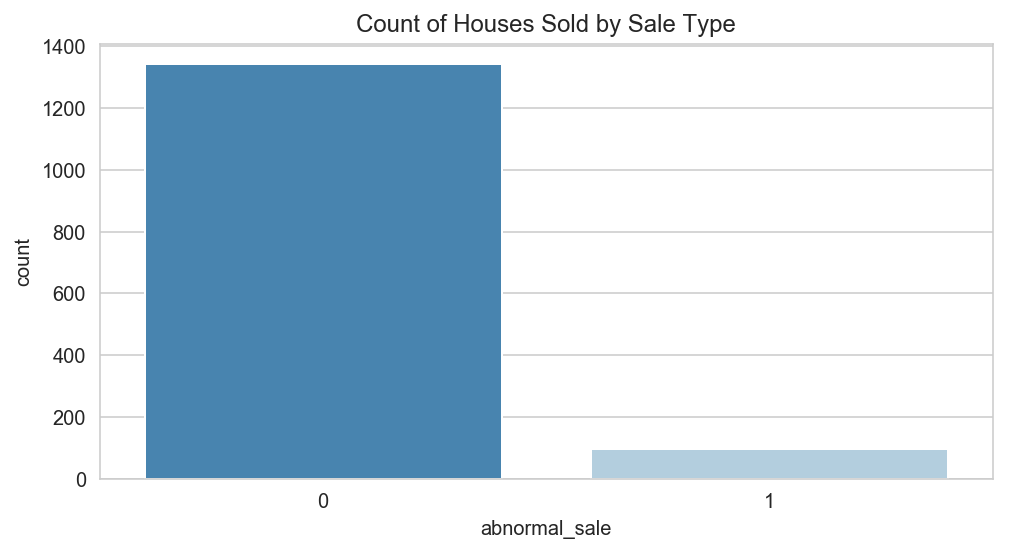

In [85]:
print("The total percentage of abnormal home sales is:", sum(df.abnormal_sale)/len(df.abnormal_sale)*100)

plt.subplots(figsize=(8,4))
plt.title("Count of Houses Sold by Sale Type")
sns.countplot(data = df, x='abnormal_sale', palette = 'Blues_r');

In [86]:
df=ohe(df)

In [87]:
#Create Train and Test set based on YrSold 2010
X_train = df.query('YrSold < 2010').drop(['abnormal_sale'],axis=1)
y_train = df.query('YrSold < 2010')['abnormal_sale']
X_test  = df.query('YrSold == 2010').drop(['abnormal_sale'],axis=1)
y_test  = df.query('YrSold == 2010')['abnormal_sale']

In [88]:
y_test.value_counts()

0    161
1      9
Name: abnormal_sale, dtype: int64

In [89]:
base_preds = np.full(len(y_test), 0)

In [90]:
base_preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [91]:
baseline_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, base_preds)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
baseline_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,161,0
is_abnormal,9,0


In [92]:
base_acc = (960 + 0) / (960 + 0 + 66 + 0)
base_acc

0.935672514619883

In [93]:
# Remember that sensitivity == recall

base_recall = (0) / (0 + 66)
base_recall

0.0

In [94]:
#A quick model
rfc = RandomForestClassifier(random_state=42)

rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)
rfc_recall = recall_score(y_test, rfc_predict)

print ("Random Forest Test Score:", rfc_recall)

Random Forest Test Score: 0.2222222222222222


In [95]:
list(rfc_predict)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [96]:
rfc_predict.sum()

3

In [97]:
rfc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, rfc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
rfc_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,160,1
is_abnormal,7,2


In [98]:
print(classification_report(y_test, rfc_predict))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       161
           1       0.67      0.22      0.33         9

   micro avg       0.95      0.95      0.95       170
   macro avg       0.81      0.61      0.65       170
weighted avg       0.94      0.95      0.94       170



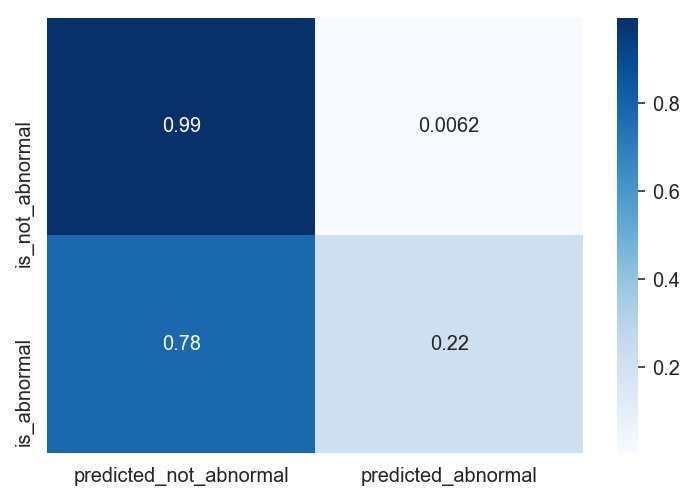

In [99]:
sns.heatmap(rfc_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

In [100]:
# recreate the full dataset used in our baseline model so that we can appropriate resample from it
data = pd.concat([X_train, 
                   pd.DataFrame(y_train, columns = ['abnormal_sale'])],
                  axis=1)

In [101]:
data.abnormal_sale.value_counts()

0    1180
1      86
Name: abnormal_sale, dtype: int64

In [102]:
# Create subsets of dataframe for the majority & minority classes
# These will be used with sklearn resample
df_maj = data[data.abnormal_sale == 0]
df_min = data[data.abnormal_sale == 1]

## Downsample majority class

In [103]:
df_downsample = resample(df_maj, replace=False, n_samples=150, random_state=240)
df_downsample = pd.concat([df_downsample, df_min])

In [104]:
X_down = df_downsample.drop('abnormal_sale', axis=1).values
y_down = df_downsample.abnormal_sale.values

In [105]:
rfc.fit(X_down,y_down)
ds_predict = rfc.predict(X_test)
ds_recall = recall_score(y_test, ds_predict)

print ("Downsample Test Score:", ds_recall)

Downsample Test Score: 0.1111111111111111


In [106]:
dsample_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, ds_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
dsample_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,147,14
is_abnormal,8,1


In [107]:
print(classification_report(y_test, ds_predict))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       161
           1       0.07      0.11      0.08         9

   micro avg       0.87      0.87      0.87       170
   macro avg       0.51      0.51      0.51       170
weighted avg       0.90      0.87      0.89       170



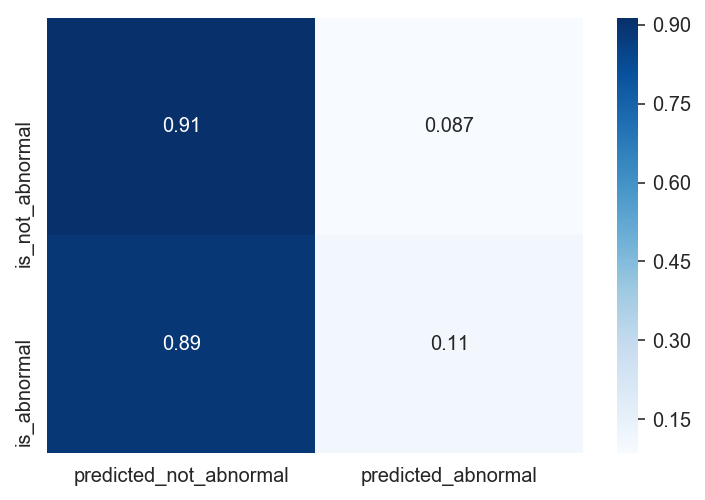

In [108]:
sns.heatmap(dsample_confusion.apply(lambda x: x/x.sum(),axis=1), annot=True, cmap = 'Blues');

## Upsample Minority Class

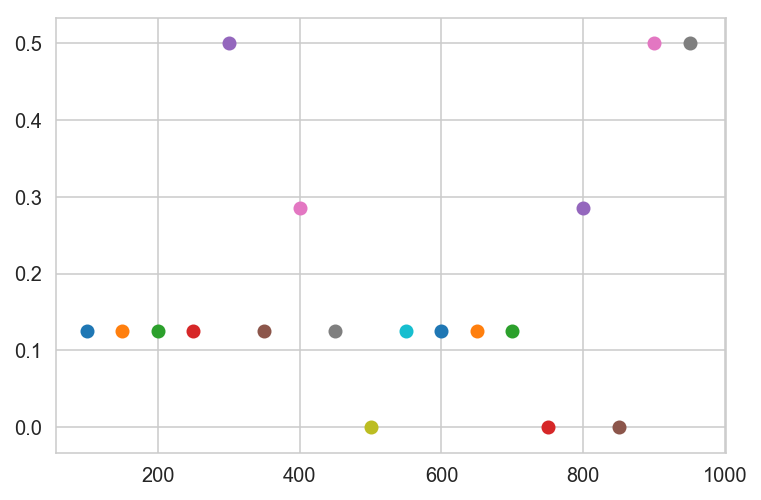

In [109]:
np.random.RandomState(42)
for k in np.arange(100, 1000, 50):
    df_upsample = resample(df_min, replace=True, n_samples=k, random_state=240)
    df_upsample = pd.concat([df_upsample, df_maj])
    X_up = df_upsample.drop('abnormal_sale', axis=1).values
    y_up = df_upsample.abnormal_sale.values
    rfc.fit(X_up,y_up)
    rfc_predict = rfc.predict(X_test)
    recall = confusion_matrix(y_test, rfc_predict).ravel()[3]/confusion_matrix(y_test, rfc_predict).ravel()[2]
#     print ('Accuracy for Minority Class for k=',k, ':', recall)
    plt.scatter(k, recall)

In [110]:
df_upsample = resample(df_min, replace=True, n_samples=650, random_state=240)
df_upsample = pd.concat([df_upsample, df_maj])

In [111]:
X_up = df_upsample.drop('abnormal_sale', axis=1).values
y_up = df_upsample.abnormal_sale.values

In [112]:
rfc.fit(X_up,y_up)
us_predict = rfc.predict(X_test)
us_recall = recall_score(y_test, us_predict)

print ("Upsample Test Score:", us_recall)

Upsample Test Score: 0.1111111111111111


In [113]:
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

In [114]:
# Create support vector classifier for non sampled data
svc = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42)

# Train classifier
model = svc.fit(X_train, y_train)

In [115]:
svc_predict = model.predict(X_test)
svc_recall = recall_score(y_test, svc_predict)

print ("SVC Test Score:", svc_recall)

SVC Test Score: 0.3333333333333333


In [116]:
list(svc_predict)

[0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1]

In [117]:
svc_predict.sum()

57

In [118]:
svc_confusion = pd.DataFrame(np.array(confusion_matrix(y_test, svc_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
svc_confusion

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,107,54
is_abnormal,6,3


In [119]:
# Create support vector classifier for non sampled data
svc = SVC(kernel='linear', class_weight='balanced', C=1.0, random_state=42)

# Train classifier
model_up = svc.fit(X_up, y_up)

In [120]:
svc.fit(X_up,y_up)
us_predict = svc.predict(X_test)
us_recall = recall_score(y_test, us_predict)

print ("Upsample Test Score:", us_recall)

Upsample Test Score: 0.2222222222222222


In [121]:
list(us_predict)

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1]

In [122]:
us_predict.sum()

60

In [123]:
svc_confusion_up = pd.DataFrame(np.array(confusion_matrix(y_test, us_predict)),
                         index = ['is_not_abnormal', 'is_abnormal'],
                        columns=['predicted_not_abnormal','predicted_abnormal'])
svc_confusion_up

,predicted_not_abnormal,predicted_abnormal
is_not_abnormal,103,58
is_abnormal,7,2


In [ ]:
#sorry unable to finish this question